Testing OpenCV's publication date text detection

In [ ]:
%matplotlib inline
import random
import time
from pathlib import Path
from shutil import copy

import cv2
import numpy as np
import pandas as pd
import pytesseract
from fuzzywuzzy import fuzz, process
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from skimage.measure import compare_ssim as ssim
from tqdm import tqdm_notebook as tqdm

import img_qc.img_qc as img_qc

plt.rc('figure', figsize=(30.0, 20.0))

In [ ]:
def get_top_percent_of_image(cv2_image, percentage):
    height, width = cv2_image.shape[:2]
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)
    image_cropped = cv2_image[y1:y2, x1:x2]
    return image_cropped


def crop_image_for_ocr(image_path, percentage=0.4, top_and_sides_padding=100):
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)
    x1 += top_and_sides_padding
    y1 += top_and_sides_padding
    x2 -= top_and_sides_padding
    y2 += top_and_sides_padding
    image = image[y1:y2, x1:x2]
    return image


def if_rgb_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        
    return np_image


def bgr_imshow(bgr_image):
    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.imshow(bgr_image)
    plt.show()

In [ ]:
# network path
# data_dir_path = Path('/Volumes/fluffy/ProjectCeres/00_for_CRL/agrtfn')

# local path
data_dir_path = Path('data/tennessee_farm_news/')

page_1_paths_list = sorted(data_dir_path.glob('**/*_0001.tif'))

# remove macOS '.' index files
page_1_paths_list = [x for x in page_1_paths_list if not str(x.stem).startswith('.')]

print(f'# of directories in {data_dir_path}:\n     {len(page_1_paths_list)}')

In [ ]:
# progress bar
# progress_label = Label('Images to copy')
# progress_bar = IntProgress(min=0, max=len(page_1_paths_list))
# progress_widget = VBox([progress_label, progress_bar])
# display(progress_widget)

# download copies of all page 1 files
print(f'Processing {len(page_1_paths_list)} images . . .')
count = 0
for image_path in tqdm(page_1_paths_list):
    copy_to_path = Path('data/').joinpath(image_path.name)
    copy(image_path, copy_to_path)
    if copy_to_path.is_file():
        count += 1
print(f'{count} images processed')    

This is processing all issues in {data_dir_path} from the Tennessee Farm News

In [ ]:
number_of_grayscale = 0
number_of_rgb = 0
gray_image_paths_list = []
rgb_image_paths_list = []
for image_path in page_1_paths_list:
    image = Image.open(image_path)
    if image.mode == 'L':
        number_of_grayscale += 1
        gray_image_paths_list.append(image_path)
    elif image.mode == 'RGB':
        number_of_rgb += 1
        rgb_image_paths_list.append(image_path)
print(f'# of grayscale: {number_of_grayscale}')
print(f'      # of rgb: {number_of_rgb}')
print(f'  total images: {number_of_grayscale + number_of_rgb}')

In [112]:
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

def return_date(image):
    
    date = []
    
    # blur image and convert to grayscale if necessary
    image = cv2.bilateralFilter(image, 11, 11, 1)
    # bgr_imshow(image)
    # image = cv2.GaussianBlur(image, (9, 9), 0)
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # show image    
    # plt.imshow(image, cmap='gray'), plt.show()
    
    # binarize
    binarized = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 55, 11)
    # plt.imshow(binarized, cmap='gray'), plt.show()
    
    # OCR
    config='-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,\  --psm 6'
    ocr_text = pytesseract.image_to_string(binarized, lang='eng', config=config)
    # Get verbose data including boxes, confidences, line and page numbers
    ocr_dataframe = pytesseract.image_to_data(binarized, lang='eng', output_type=pytesseract.Output.DATAFRAME, config=config)
    # test_boxes = pytesseract.image_to_boxes(binarized, lang='eng', config=config)
    
    # split OCR results and look for "months"
    # for line in text.split('\n'):
    #     words = line.split()
    #     for index, word in enumerate(words):
    #         if word.lower() in months:
    #             date.append(words[index:])
                
    # plt.imshow(binarized, cmap='gray'), plt.show()
    # print(f'ocr_dataframe: {ocr_dataframe}')
    return ocr_dataframe, ocr_text #, binarized

In [116]:
image_path = page_1_paths_list[67]

In [141]:
roi_box_list = ['text', 'left', 'top', 'width', 'height']
from autocorrect import spell

def get_date_crop(image_path):
    
    box = False
    month_crop = []
    date_crop = []
    
    image = cv2.imread(str(image_path))
    image = get_top_percent_of_image(image, 0.4)

    ocr_dataframe = return_date(image)
    # print(ocr_dataframe['text'])
    
    # assume the first month we find is correct
    month_found = False
    # print(ocr_dataframe)
    
    for index, row in enumerate(ocr_dataframe.itertuples()):
        # print(f'row: {row}')
        text = row.text
        print(index, text)
        if not month_found:
            if isinstance(text, float):
                pass
            else:
                # print(text)
                test_text = spell(text)
                if test_text:
                    text = test_text
                # print(text)
                if text.lower() in months:
                    # print(ocr_dataframe.iloc[index])
                    box = []
                    for edge in roi_box_list:
                        print(box)
                        print(ocr_dataframe.iloc[index][edge])
                        box.append(ocr_dataframe.iloc[index][edge])
                    month_found = True

    if not month_found:  # add all text into a single string and find closest match to a month
        # TO DO!
        pass
        
    if box:
        # print(box)
        box = [int(x) if x != box[0] else x for x in box]
        text, x1, y1, box_width, box_height = box
        x2 = x1 + box_width
        y2 = y1 + box_height

        # print(box)
        image_to_crop = cv2.imread(str(image_path))
        width, height = image_to_crop.shape[:2]
        month_crop = image_to_crop[y1:y2, x1:x2]
        # bgr_imshow(month_crop)

        # crop image and get date box based on finding the month
        date_x1 = x1 - 30
        date_x2 = x1 + 600
        date_y1 = y1 - 30
        date_y2 = y2 + 30
        date_x1 = max(0, date_x1)
        date_y1 = max(0, date_y1)
        date_x2 = min(date_x2, width)
        date_y2 = min(date_y2, height)

        date_crop = image_to_crop[date_y1:date_y2, date_x1:date_x2]
        # bgr_imshow(date_crop)

    # return cropped images
    return month_crop, date_crop

In [142]:
image_path = page_1_paths_list[72]
month_crop, date_crop = get_date_crop(image_path)
if date_crop:
    date_crop = if_rgb_convert_to_gray(date_crop)
    plt.imshow(date_crop, cmap='gray'), plt.show()
else:
    print('No date found')

0 nan
1 nan
2 nan
3 nan
4 ee
5 Bn
6 nn
7 nan
8 Los
9 nan
10 AGRICULTURAL
11 ,
12 Pa
13 nan
14 EXTENSION
15 SERVICE
16 ,
17 iyih
18 nan
19 7
20 be
21 nan
22 i
23 i
24 ,
25 re
26 nan
27 University
28 of
29 Tennessee
30 ,
31 Po
32 nan
33 a
34 nan
35 Knoxville
36 L
37 Thy
38 ae
39 nan
40 a
41 be
42 nan
43 bd
44 nan
45 ,
46 a
47 nan
48 DAIRY
49 RATIONS
50 7
51 ,
52 ee
53 nan
54 DONT
55 NEED
56 So
57 nan
58 GROUND
59 HAY
60 Co
61 nan
62 Grinding
63 hay
64 and
65 adding
66 it
67 to
68 the
69 dairy
70 cows
71 concentrate
72 ration
73 oe
74 nan
75 not
76 only
77 makes
78 the
79 ration
80 more
81 expensive,
82 but
83 it
84 also
85 increases
86 the
87 nan
88 fiber
89 content
90 of
91 the
92 feed
93 and
94 affects
95 the
96 butterfat
97 test,
98 os
No date found


Processing 0012_004266_000005_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 fo
8 RELEASED
9 TODAY
10 nan
11 COOPERATIVE
12 AGRICULTURAL
13 EXTENSION
14 WORK
15 oo
16 ,
17 nan
18 nan
19 COLLEGE
20 OF
21 AGRICULTURE,
22 UNIVERSITY
23 OF
24 TENNESSEE
25 Looe
26 nan
27 TENNESSEE
28 DEPARTMENT
29 OF
30 AGRICULTURE
31 nan
32 TENNESSEE
33 BOARD
34 OF
35 EDUCATION,
36 AND
37 OTHER
38 AGENCIES
39 ,
40 nan
41 nan
42 DIVISION
43 OF
44 EXTENSION
45 ,
46 ,
47 nan
48 nan
49 Cet
50 Ae
51 pinecrom
52 ,
53 For
54 Re
55 le
56 age
57 nan
58 nan
59 KNOXVILLE,
60 TENNESSEE
61 ,
62 nan
63 nan
64 oo
65 ,
66 Monday,
67 July
[]
July
['July']
2374
['July', 2374]
408
['July', 2374, 408]
132
['July', 2374, 408, 132]
60
68 16,
69 1921,
70 nan
71 cs
72  PENNESSEE
73 FARM
74 NEWS
75 nan
76 Prepared
77 by
78 the
79 Division
80 of
81 Extension,
82 ,
83 oo
84 nan
85 nan
86 a
87 University
88 of
89 Tennessee,
90 nan
91 nan
92 ,
93 ,
94 nan
95 nan
96 oo
97 COUNTY
98 DAYS
99 AT
100 WEST
101 TENNESSEB
102 o

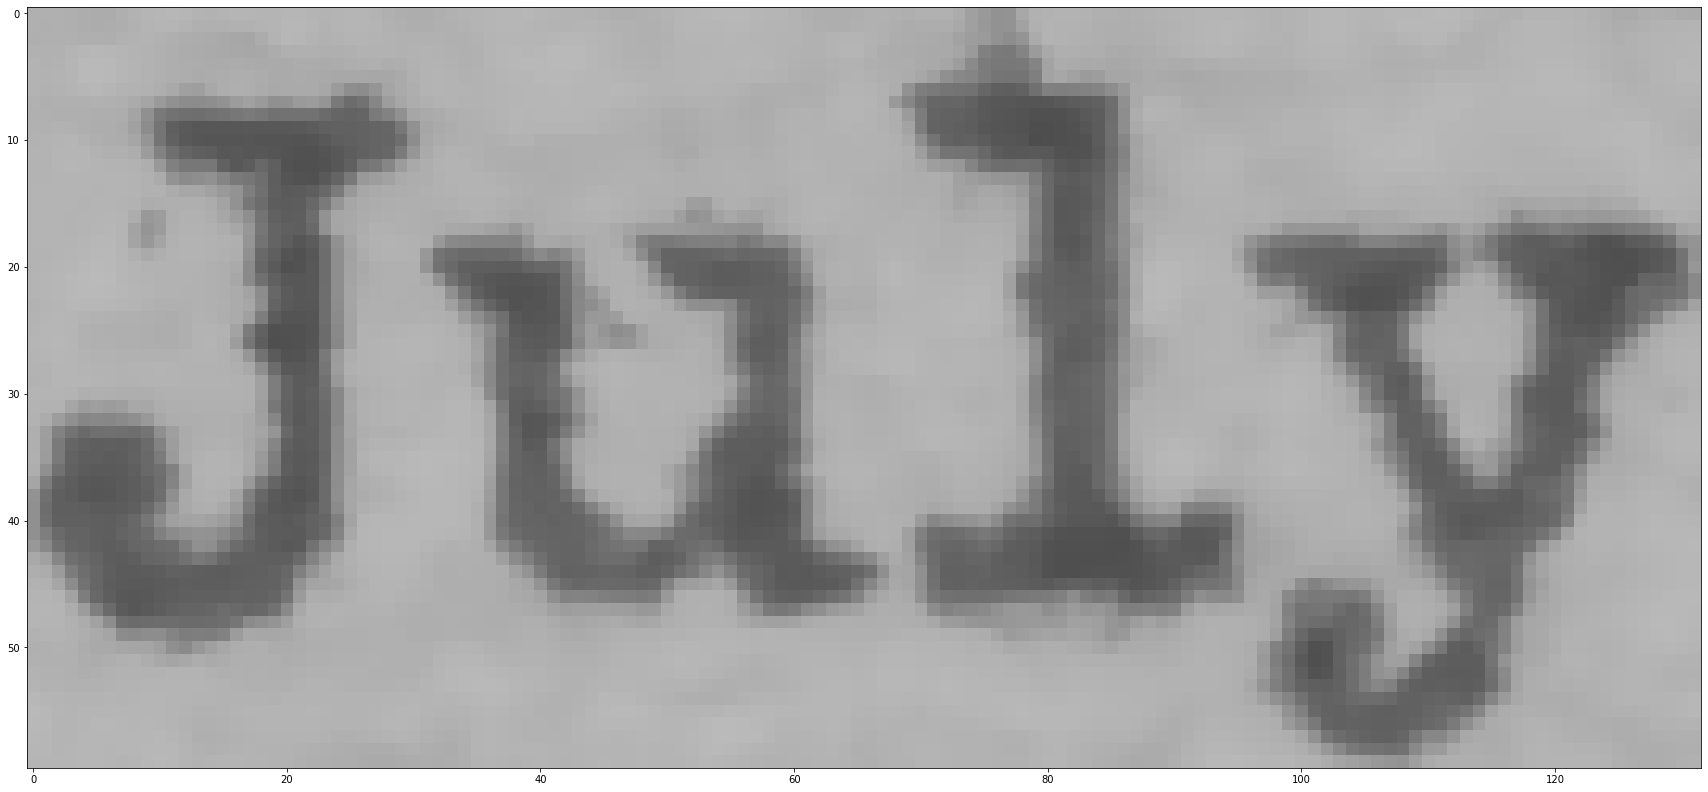

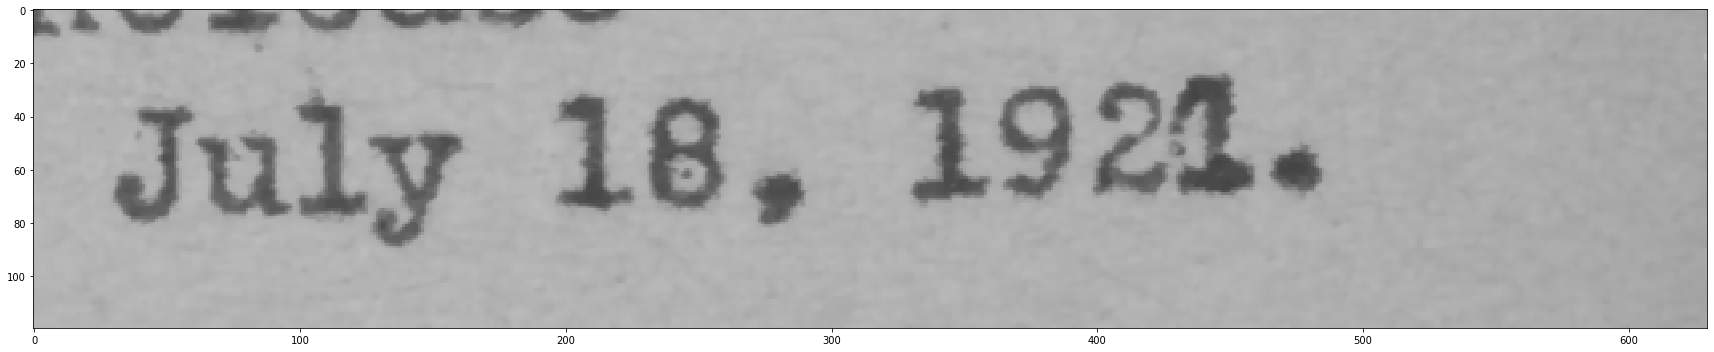

Processing 0012_004266_000045_0001.tif
0 nan
1 nan
2 nan
3 nan
4 ,
5 y
6 4
7 ,
8 nan
9 SPECIAL
10 NEWS
11 SERVICE
12 a
13 nan
14 Cope
15 svarece
16 beonatuent
17 Or
18 nomcuTune
19 ,
20 For
21 Release
22 nan
23 TENNESSEE
24 DEPARTMENT
25 OF
26 AGRICULTURE
27 May
[]
May
['May']
2384
['May', 2384]
240
['May', 2384, 240]
95
['May', 2384, 240, 95]
54
28 8,
29 1922
30 nan
31 TENNESSEE
32 BOARD
33 OF
34 EDUCATION,
35 AND
36 OTHER
37 AGENCIES
38 nan
39 DIVISION
40 OF
41 EXTENSION
42 ,
43 ,
44 nan
45 Ch
46 LaAnifgan
47 Ormacton
48 nan
49 Prepared
50 by
51 the
52 Division
53 of
54 Extension,
55 nan
56 ,
57 sr
58 ,
59 University
60 of
61 Tennessee
62 Wo,
63 nan
64 co
65 MANY
66 TENNESSES
67 FARMERS
68 JJ
69 ,
70 nan
71 oO
72 BUYING
73 GOOD
74 BULLS
75 nan
76 oo
77 pe
78 SO
79 nan
80 oe,
81 One
82 of
83 the
84 most
85 erntifying
86 developments
87 in
88 the
89 progress
90 of
91 Livestock
92 nan
93 in
94 Tennessee
95 of
96 late
97 is
98 the
99 keen
100 interest
101 formers
102 are
103 showing
104 

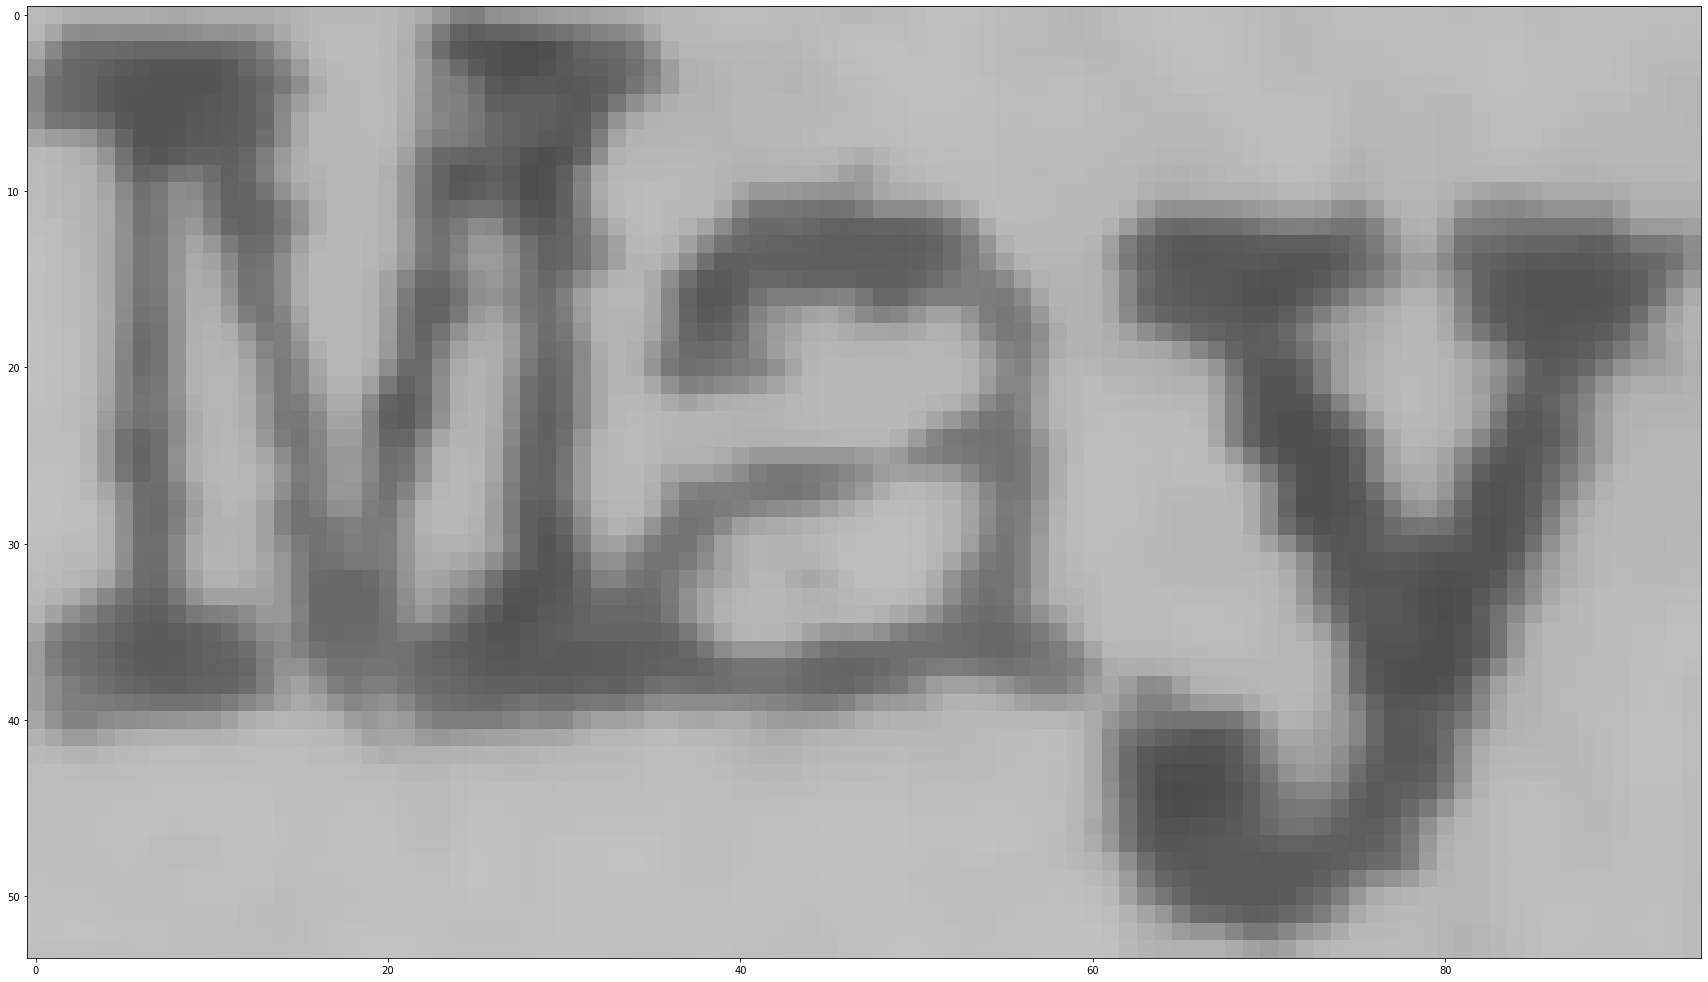

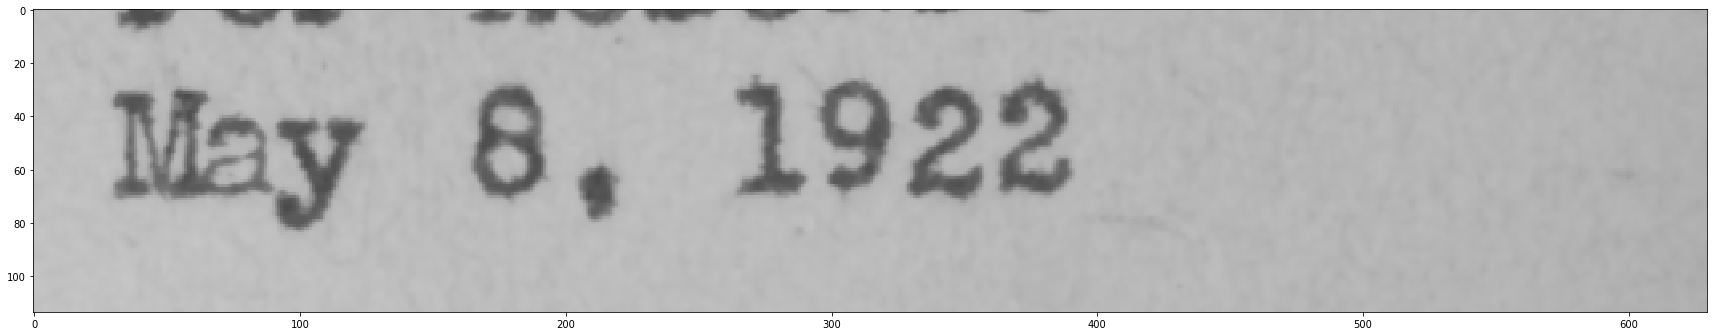

Processing 0012_004266_000075_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 ,
8 ,
9 nan
10 nan
11 SOO
12 TED
13 STATES
14 DEPARTMENT
15 OF
16 AOMICULTURE
17 YY
18 nan
19 TENNESSEE
20 DEPARTMENT
21 OF
22 AGRICULTURE
23 1
24 pe
25 For
26 Relorse
27 nan
28 TENNESSEE
29 BOARD
30 OF
31 EDUCATION,
32 AND
33 OTHER
34 AGENCIES
35 nan
36 nan
37 DIVISION
38 OF
39 EXTENSION
40 ,
41 Dearmbor
42 4,
43 1922
44 nan
45 nan
46 Cho
47 heaA
48 Rif
49 gin
50 DIRECTOR
51 e
52 nan
53 KNOXVILLE,
54 TENNESSEE
55 ,
56 ,
57 nan
58 nan
59 ,
60 Prepared
61 by
62 the
63 Division
64 of
65 Extension,
66 a
67 nan
68 ne
69 University
70 of
71 Tennessee
72 oe
73 nan
74 nan
75 ,
76 ,
77 oe
78 i
79 ,
80 nan
81 a
82 Be
83 COTTON
84 GROTURS
85 OF
86 Test,
87 SO
88 nan
89 At
90 TIN
91 TGS
92 ES
93 ORG
94 NIZE
95 nan
96 SS
97 Proj
98 present
99 indicstzons
100 the
101 great
102 bulk
103 of
104 the
105 cottm
106 produced
107 in
108 Vest
109 nan
110  Tennegsce
111 in
112 1923
113 will
114 b
115 sold
116 coopere

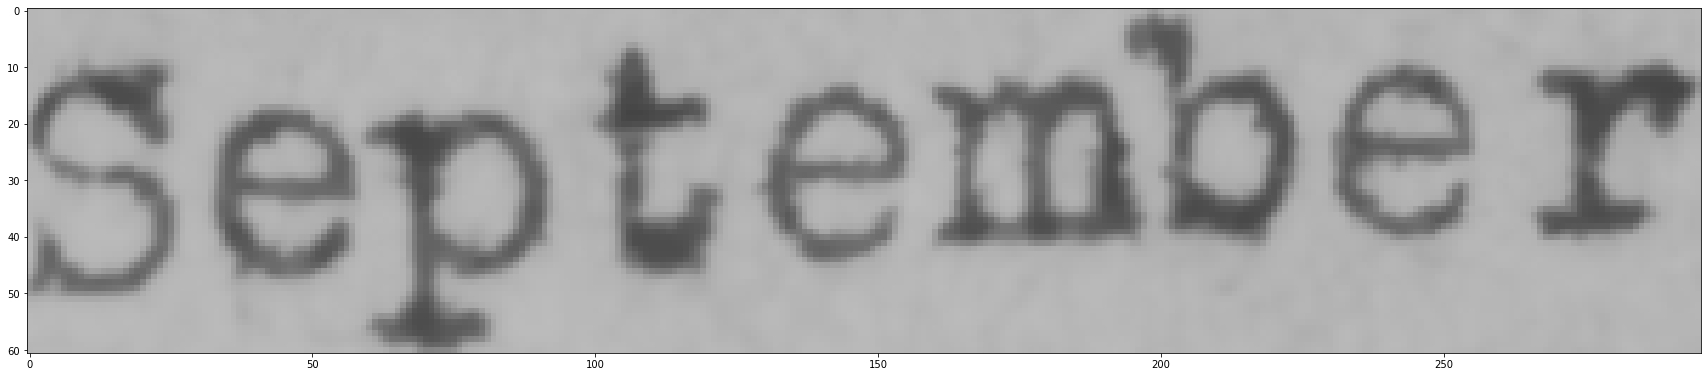

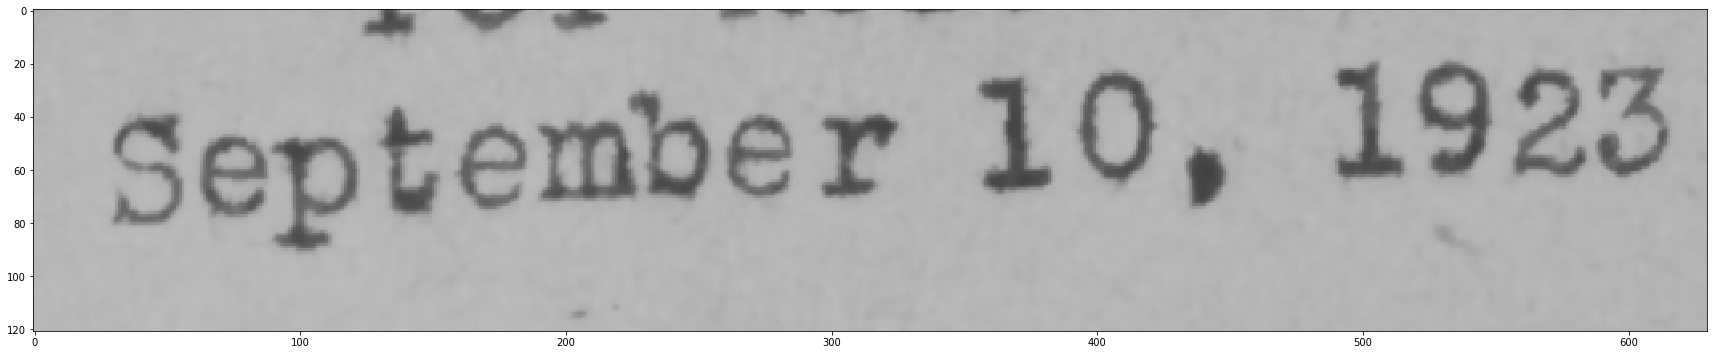

Processing 0012_004266_000129_0001.tif
0 nan
1 nan
2 nan
3 nan
4 ,
5 nan
6 SPECIAL
7 NEWS
8 SERVICE
9 ee
10 OS
11 nan
12 COOPERATIVE
13 AGRICULTURAL
14 EXTENSION
15 WORK
16 ,
17 f
18 ,
19 nan
20 ,
21 UNITED
22 STATES
23 DEPARTMENT
24 OF
25 AGRICULTURE
26 nan
27 TENNESSEE
28 DEPARTMENT
29 OF
30 AGRICULTURE
31 nan
32 6
33 TENNESSEE
34 BOARD
35 OF
36 EDUCATION,
37 AND
38 OTHER
39 AGENCIES
40 ,
41 nan
42 DIVISION
43 OF
44 EXTENSION
45 ,
46 ,
47 For
48 Relea
49 se
50 nan
51 KNOXVILLE,
52 TENNESSEE
53 Oo
54 i
55 Co
56 ,
57 ,
58 nan
59 ,
60 TENNESSEE
61 FARM
62 NEWS
63 nan
64 Prepared
65 by
66 the
67 Division
68 of
69 Extension,
70 nan
71 ,
72 University
73 of
74 Tennessee
75 nan
76 COUNTY
77 AGES
78 HOLD
79 ANTUiL
80 MN
81 TTING
82 nan
83 ,
84 AP
85 ULT,
86 4G
87 COLLEET
88 nan
89 e
90 County
91 agriculture1
92 egents
93 which
94 ere
95 employed
96 in
97 fifty
98 sounties
99 of
100 the
101 state
102 nan
103 end
104 home
105 demunstrstivn
106 egents
107 wh
108 sre
109 werking
110 in
111 thirt

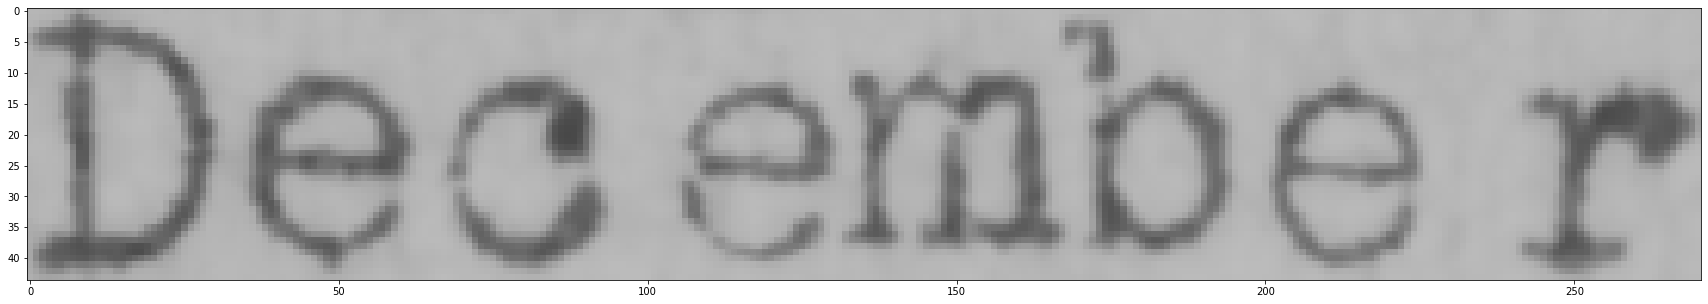

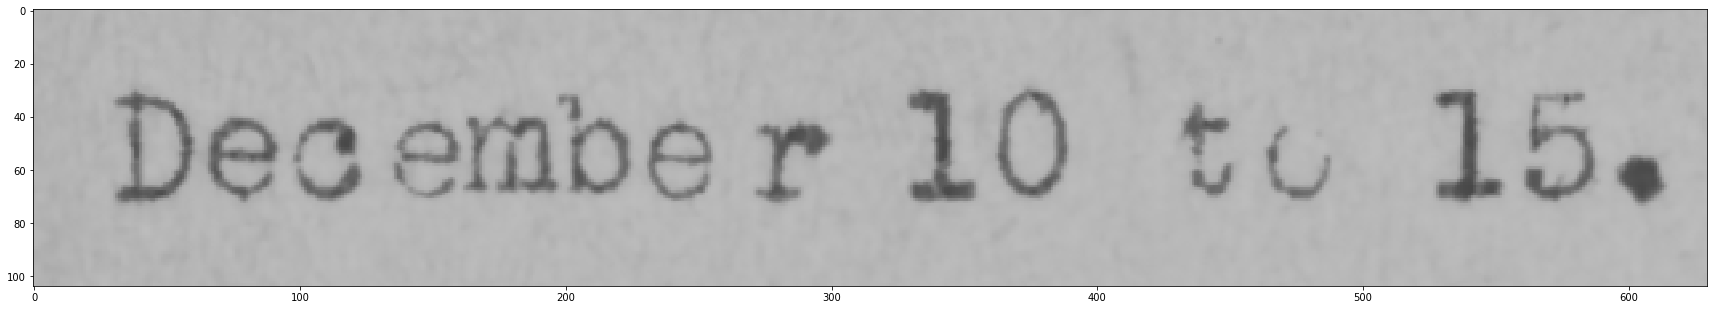

Processing 0012_004266_000142_0001.tif
0 nan
1 nan
2 nan
3 nan
4 a
5 ,
6 nan
7 nan
8 SPECIAL
9 NEWS
10 SERVICE
11 nan
12 COOPERATIVE
13 AGRICULTURAL
14 EXTENSION
15 WORK
16 nan
17 UNITED
18 STATES
19 OEPARTMENT
20 OF
21 AGRICULTURE
22 nan
23 TENNESSEE
24 DEPARTMENT
25 OF
26 AGRICULTURE
27 ee
28 oo
29 For
30 Release
31 nan
32 7
33 TENNESSEE
34 BOARD
35 OF
36 EDUCATION,
37 ANO
38 OTHER
39 AGENCIES
40 nan
41 DIVISION
42 OF
43 EXTENSION
44 March
[]
March
['March']
2041
['March', 2041]
281
['March', 2041, 281]
175
['March', 2041, 281, 175]
46
45 17,
46 1924
47 nan
48 KNOXVILLE,
49 TeNNesace
50 ,
51 nan
52 Prepared
53 by
54 the
55 Division
56 of
57 Extension,
58 ,
59 nan
60 ,
61 ,
62 University
63 of
64 Tennessee
65 nan
66 ,
67 i
68 TENNESSES
69 GROVERS
70 MUST
71 IMPROVE
72 QUALITY
73 a
74 nan
75 QF
76 LAMBS
77 OR
78 LOSE
79 OUT
80 IN
81 HARKETS
82 nan
83 eee
84 creer
85 ,
86 nan
87 nan
88 b
89 Noa
90 ,
91 f
92 co,
93 nan
94 nan
95 Li
96 Recently
97 G
98 Le
99 Vatkins,
100 Naskvi
101 ile
10

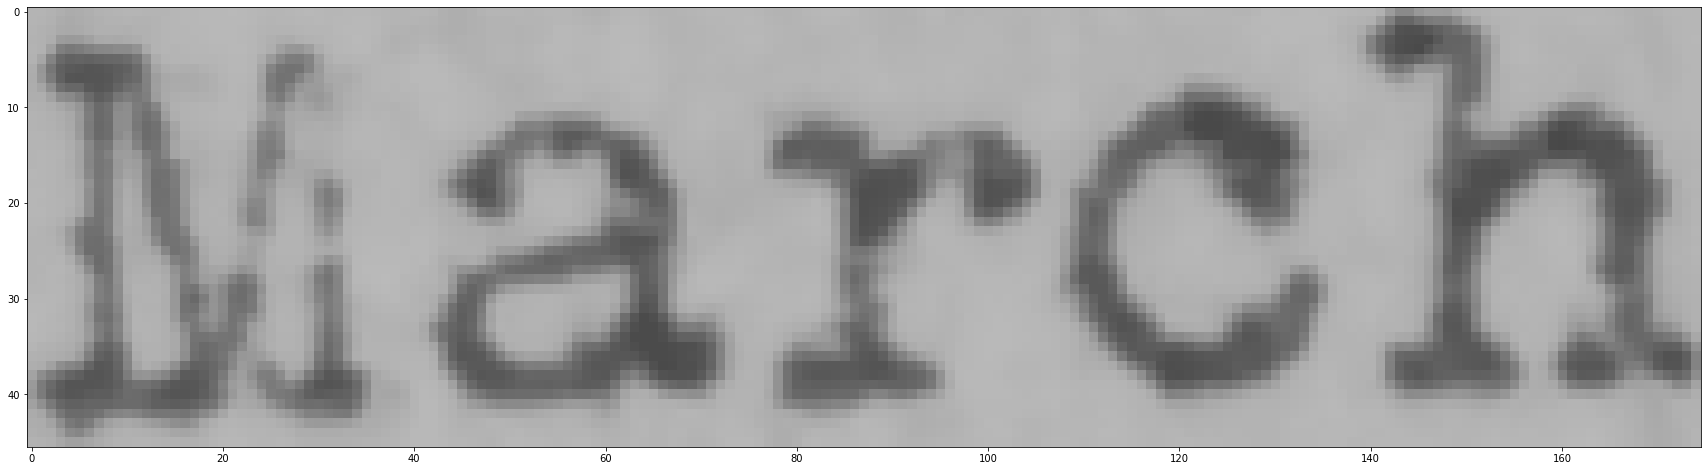

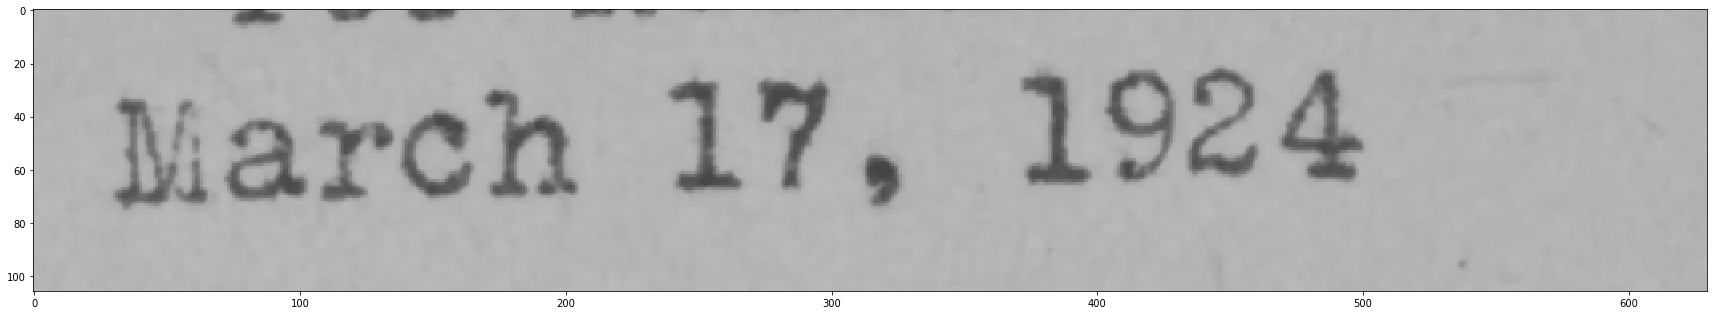

Processing 0012_004266_000154_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 ,
8 For
9 Release
10 nan
11 eT
12 Jane
13 9,
14 1924
15 nan
16 Wy
17 TENNESSEE
18 BOARD
19 OF
20 EDUCATION,
21 AND
22 OTHER
23 AGENCIES
24 nan
25 DIVISION
26 OF
27 EXTENSION
28 nan
29 NOXVILLE,
30 TE
31 lose
32 ,
33 ,
34 nan
35 me
36 TENNESSEE
37 FARM
38 NEWS
39 nan
40 Prepared
41 by
42 the
43 Division
44 of
45 Extension,
46 Se
47 nan
48 oS
49 University
50 of
51 Tennessee
52 nan
53 FERTILE
54 EGGS
55 CAUSE
56 LOSS
57 nan
58 a
59 TO
60 FARMERS
61 EVERY
62 SUMMER
63 ,
64 nan
65 ,
66 ay
67 nan
68 Sb
69 A
70 large
71 part
72 of
73 the
74 loss
75 caused
76 by
77 eggs
78 spoiling
79 in
80 warm
81 weather
82 can
83 be
84 pre
85 nan
86 vented
87 by
88 producing
89 only
90 infertile
91 eggs
92 during
93 the
94 late
95 spring
96 and
97 summer
98 say
99 oe
100 nan
101 poultry
102 spefialists
103 of
104 the
105 Ag
106 College
107 Extension
108 Service,
109 This
110 loss,
111 whichis
112 ,
113 nan
114 oy
11

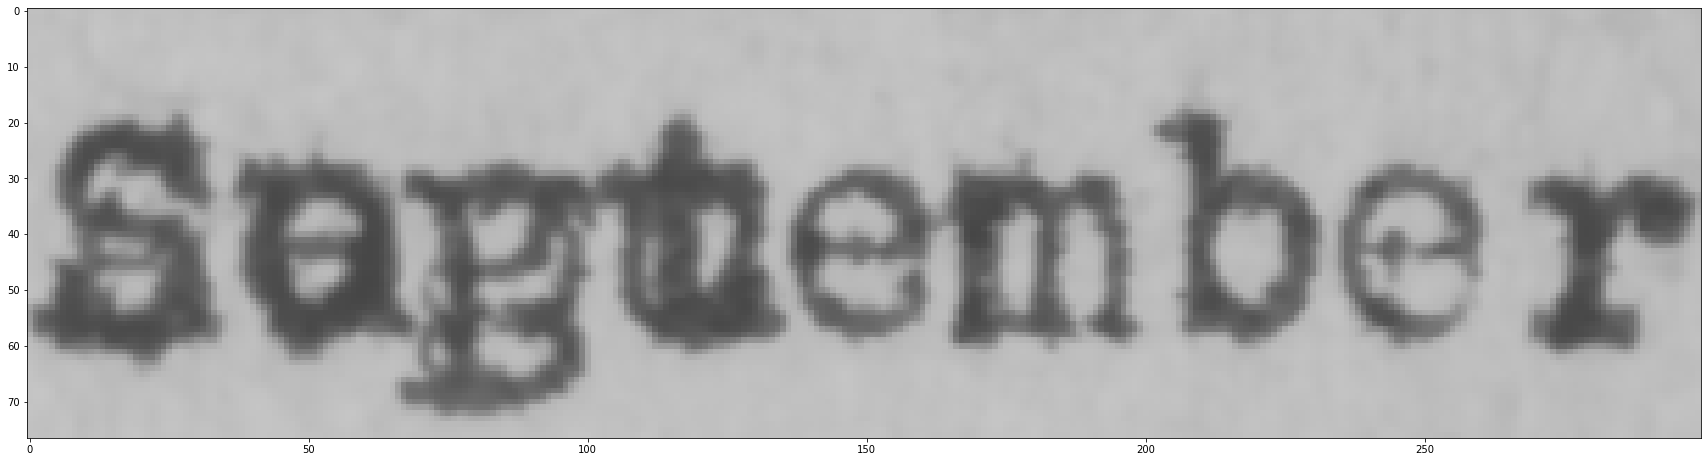

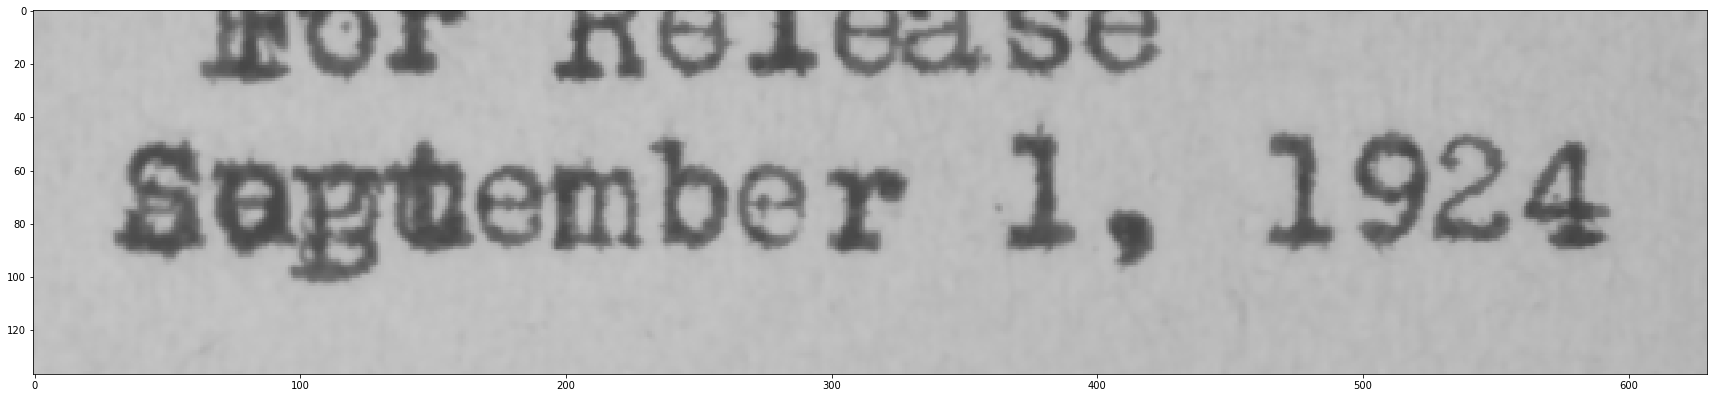

Processing 0012_004266_000179_0001.tif
0 nan
1 nan
2 nan
3 nan
4 N
5 Lo
6 nan
7 SPECIAL
8 NEWS
9 SERVICE
10 nan
11 SO
12 ENITED
13 StATED
14 DEPARTMENT
15 OF
16 AGRICULTURE
17 nan
18 ,
19 COLLEGE
20 OF
21 AGRICULTURE,
22 UNIVERSITY
23 OF
24 TENNESSEE
25 ,
26 nan
27 TENNESSEE
28 BOARD
29 OF
30 EDUCATION,
31 ANO
32 OTHER
33 AGENCIES
34 nan
35 DIVISION
36 OF
37 EXTENSION
38 ,
39 nan
40 Ch
41 LA
42 Rifge
43 ommecton
44 nan
45 ,
46 KNOXVILLE,
47 TENNESSEE
48 ,
49 ,
50 ,
51 nan
52 ne
53 Prepared
54 by
55 the
56 Division
57 of
58 Extension,
59 oe
60 oe
61 nan
62 Se
63 University
64 of
65 Tennessee
66 nan
67 Oe
68 a
69 For
70 Release,
71 ,
72 nan
73 Ca
74 December
[]
December
['December']
1973
['December', 1973]
871
['December', 1973, 871]
266
['December', 1973, 871, 266]
45
75 1,
76 1924,
77 nan
78 oo
79 CLUB
80 GIRL
81 MAKES
82 7
83 nan
84 yt
85 oo,
86 OUTSTANDING
87 RECORD
88 ,
89 a
90 74
91 nan
92 Canned
93 638
94 Quarts
95 Fruit
96 Wins
97 Breadmaking
98 nan
99 Honors
100 Had
101 Garden
1

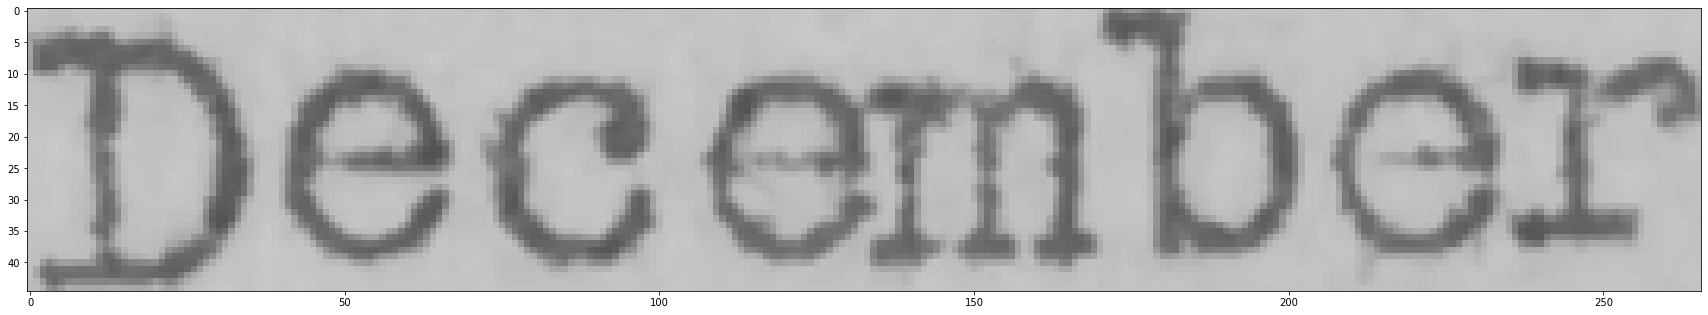

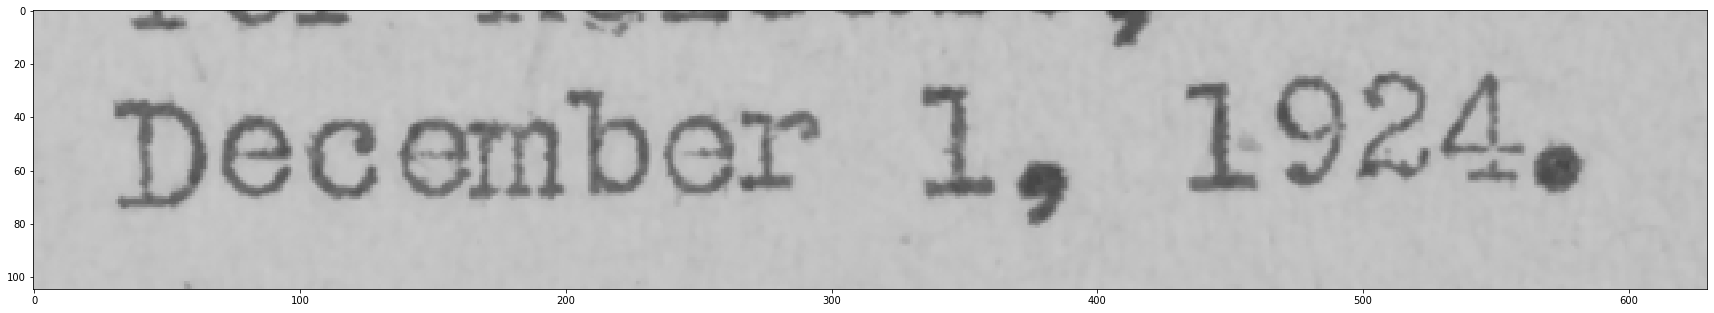

Processing 0012_004266_000190_0001.tif
0 nan
1 nan
2 nan
3 nan
4 o
5 oO
6 ,
7 ,
8 nan
9 SPECIAL
10 NEWS
11 SERVICE
12 oO,
13 i
14 nan
15 ,
16 COOPERATIVE
17 AGRICULTURAL
18 EXTENSION
19 WORK
20 ,
21 nan
22 a
23 UNITED
24 STATES
25 DEPARTMENT
26 OF
27 AGRICULTURE
28 nan
29 W
30 COLLEGE
31 OF
32 AGRICULTURE,
33 UNIVERSITY
34 OF
35 TENNESSEE
36 ,
37 nan
38 ,
39 ,
40 TENNESSEE
41 BOARD
42 OF
43 EDUCATION,
44 AND
45 OTHER
46 AGENCIES
47 nan
48 x
49 DIVISION
50 OF
51 EXTENSION
52 ,
53 nan
54 Ch
55 La
56 Anifge
57 DIRECTOR
58 ,
59 nan
60 KNOXVILLE,
61 TENNESSEE
62 ,
63 ,
64 nan
65 Lo
66 TENNESSEE
67 FARM
68 NEWS
69 nan
70 7
71 a
72 ,
73 Prepared
74 by
75 the
76 Division
77 of
78 Extension,
79 nan
80 a
81 am
82 University
83 of
84 Tennesstees
85 234270
86 nan
87 ee
88 4
89 For
90 Release,
91 jo
92 nan
93 i
94 oo
95 February
[]
February
['February']
1795
['February', 1795]
837
['February', 1795, 837]
292
['February', 1795, 837, 292]
63
96 16,
97 1925,
98 oo
99 nan
100 oo
101 TENNESSEE
102 CHEES

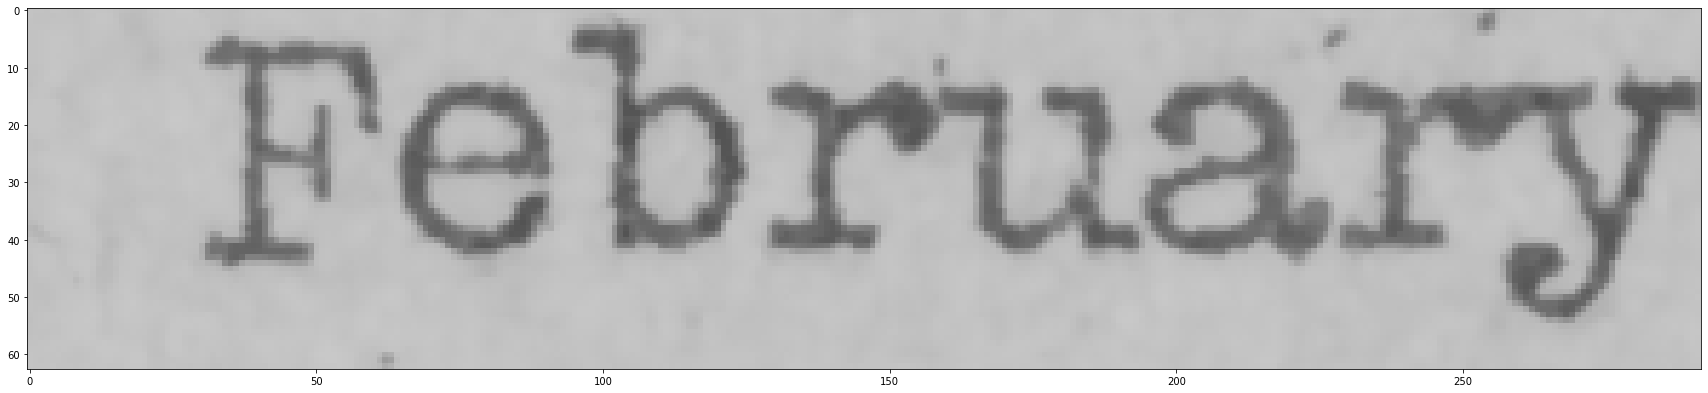

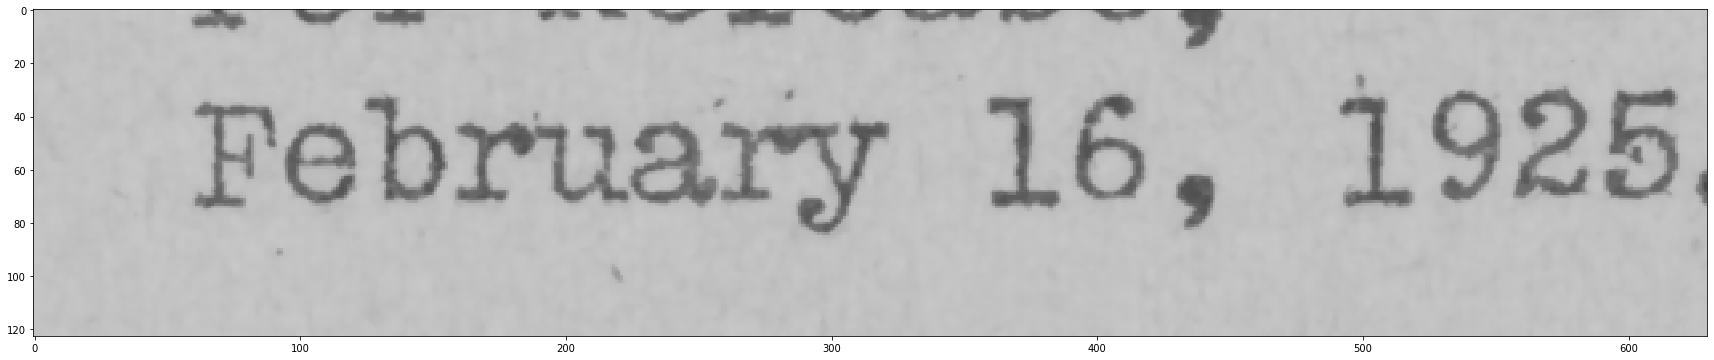

Processing 0012_004266_000204_0001.tif
0 nan
1 nan
2 nan
3 nan
4 ,
5 oe
6 nan
7 SPECIAL
8 NEWS
9 SERVICE
10 7
11 nan
12 COOPERATIVE
13 AGRICULTURAL
14 EXTENSION
15 WORK
16 nan
17 COLLEGE
18 OF
19 AGRICULTURE,
20 UNIVERSITY
21 OF
22 TENNESSEE
23 a
24 nan
25 TENNESSEE
26 BOARD
27 OF
28 EDUCATION,
29 AND
30 OTHER
31 AGENCIES
32 nan
33 DIVISION
34 OF
35 EXTENSION
36 ,
37 4
38 L
39 nan
40 ae
41 CLA
42 AR
43 fg
44 DIRECTOR
45 nan
46 KNOXVILLE,
47 TENNESSEE
48 4
49 nan
50 CO
51 ,
52 Prepared
53 by
54 the
55 Division
56 of
57 Extension,
58 oO
59 nan
60 oe
61 University
62 of
63 Tennessee
64 SO
65 nan
66 a
67 For
68 Release,
69 nan
70 ot
71 7
72 May
[]
May
['May']
2005
['May', 2005]
935
['May', 2005, 935]
101
['May', 2005, 935, 101]
49
73 25,
74 1925,
75 a,
76 nan
77 a
78 NEW
79 ERA
80 FOR
81 AGRICULTURE
82 Oo
83 nan
84 SO
85 IS
86 DAWNING
87 oo
88 nan
89 Oldest
90 Organization
91 of
92 Farmers
93 In
94 South
95 Sees
96 a
97 nan
98 cs
99 ee
100 Golden
101 Prospects
102 For
103 wen
104 Who
105 W

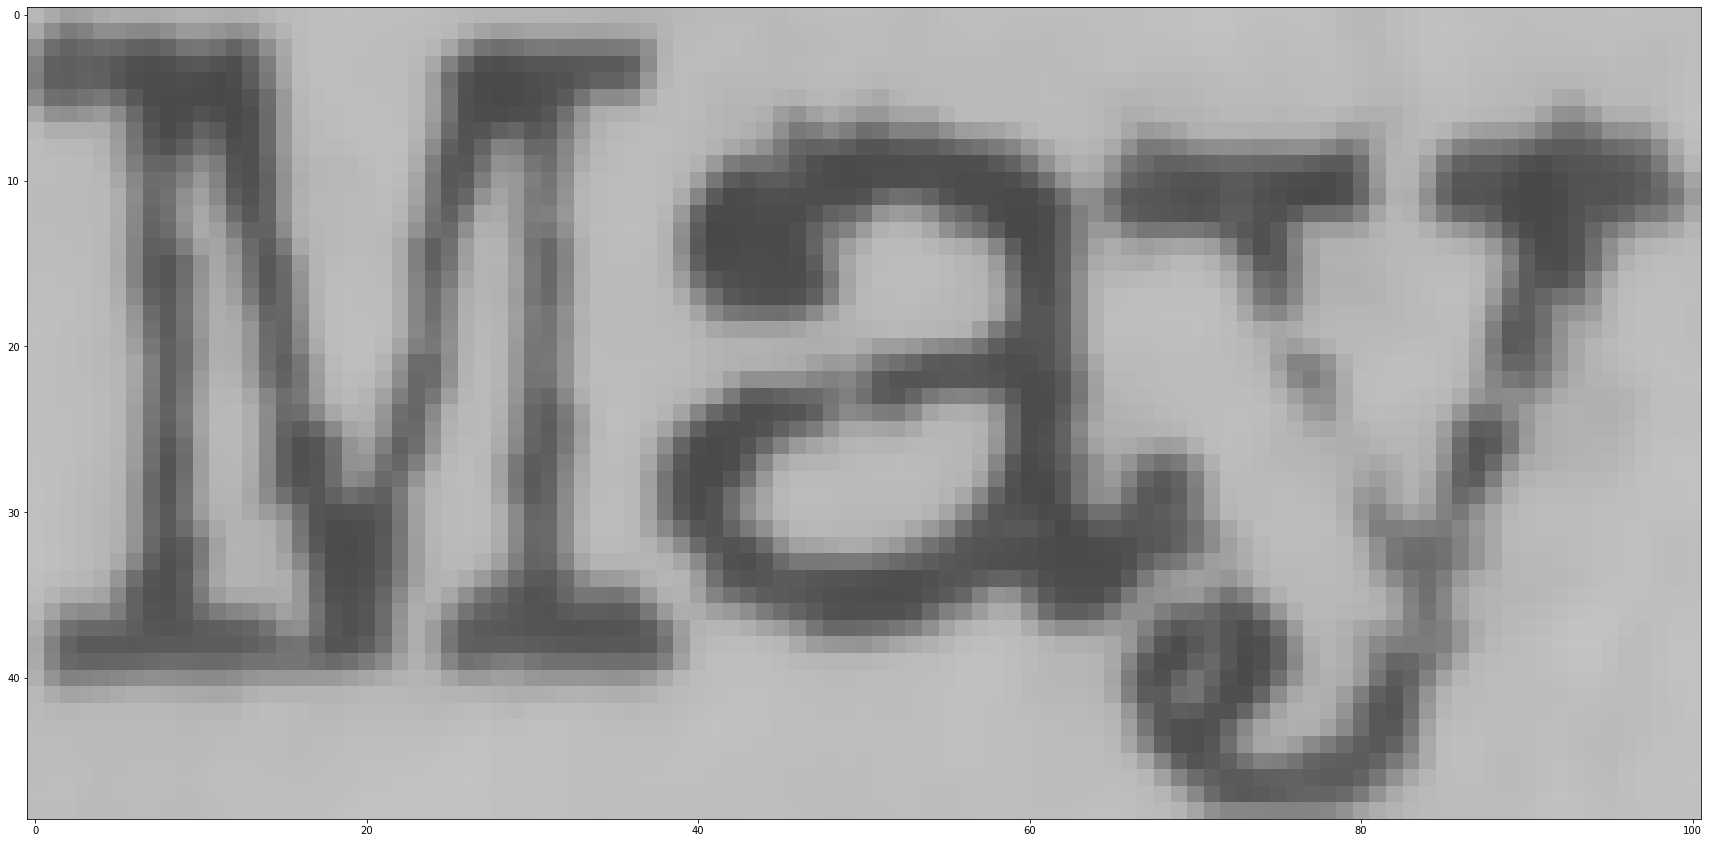

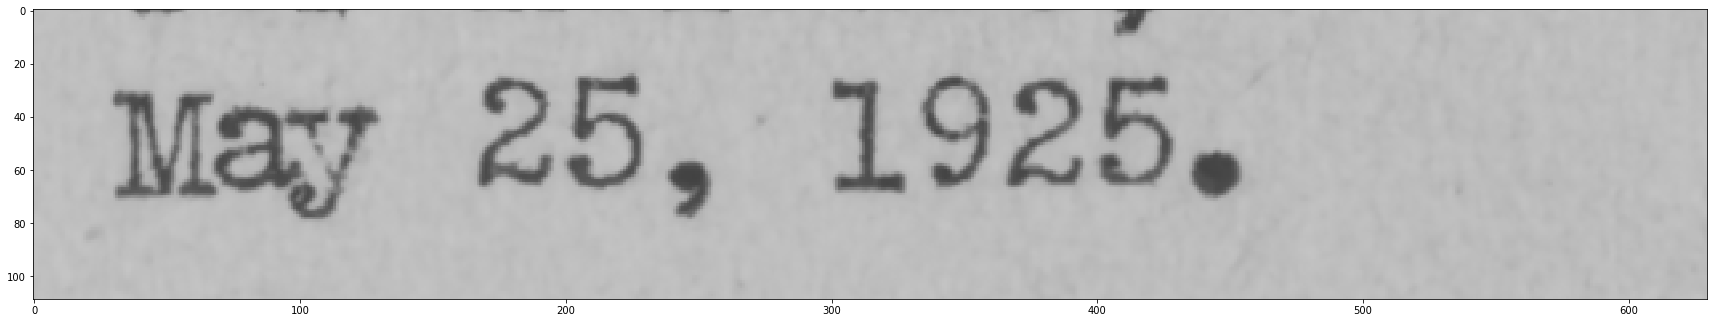

Processing 0012_004266_000219_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 7
8 ,
9 nan
10 COOPERATIVE
11 AGRICULTURAL
12 EXTENSION
13 WORK
14 nan
15 See
16 TE
17 et
18 to
19 ee
20 eh
21 ASENCIES
22 ,
23 ,
24 os
25 nan
26 DIVISION
27 OF
28 EXTENSION
29 o
30 ,
31 nan
32 KNOXVILLE
33 Tennessee
34 ,
35 nan
36 a
37 4
38 oe
39 Prepared
40 by
41 the
42 Division
43 of
44 Extension,
45 oo
46 nan
47 University
48 of
49 Tennessee
50 co
51 nan
52 For
53 Release
54 nan
55 September
[]
September
['September']
2317
['September', 2317]
815
['September', 2317, 815]
295
['September', 2317, 815, 295]
59
56 7,
57 1925,
58 nan
59 os
60 oe
61 Vs
62 oO
63 nan
64 oe
65 Lo
66 Ce
67 ,
68 ,
69 A
70 HARD
71 WINTER
72 ,
73 Oo
74 nan
75 hig
76 is
77 Septenbor
78 8th
79 of
80 tho
81 dry
82 sumbp,
83 ee
84 oO
85 nan
86 Wherever
87 there
88 is
89 talk
90 of
91 the
92 drouth
93 there
94 are
95 visions
96 of
97 empty
98 hay
99 mows,
100 per
101 nan
102 haps
103 a
104 hard
105 winter
106 and
107 late
108

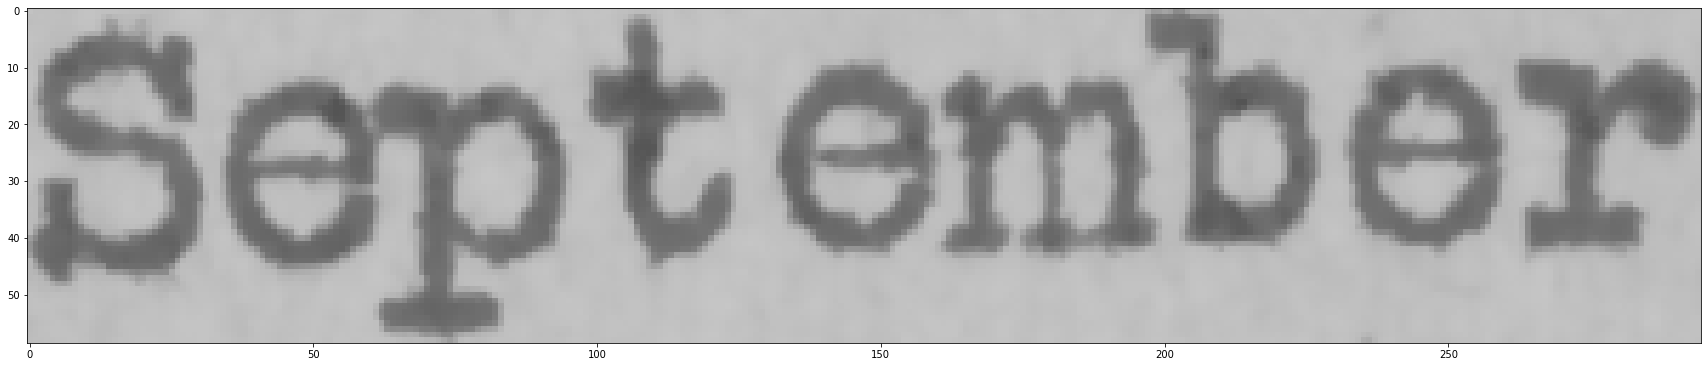

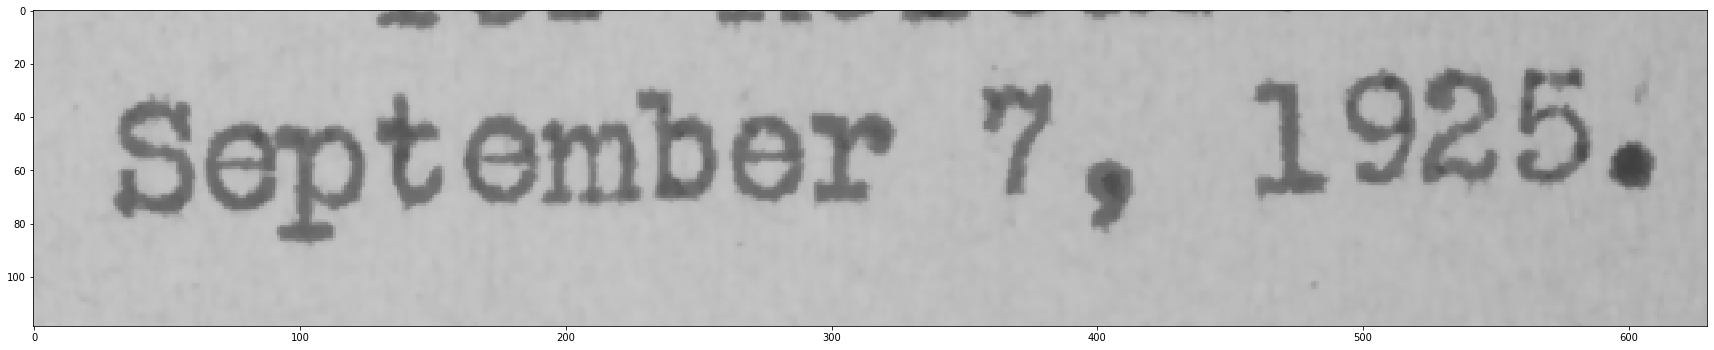

Processing 0012_004266_000242_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 Be
8 Oo
9 nan
10 SORTED
11 STATES
12 DEPARTMENT
13 OF
14 ROMICULTURE
15 nan
16 TENNESSEE
17 DEPARTMENT
18 OF
19 ACS
20 TU
21 em
22 AGENCIES
23 nan
24 DIVISION
25 OF
26 EXTENSION
27 nan
28 KNOXVILLE,
29 TE
30 coste
31 ,
32 ,
33 ,
34 nan
35 an
36 TENNESSEE
37 FARM
38 NEWS
39 ,
40 nan
41 bo
42 Prepared
43 by
44 the
45 Division
46 of
47 Extension,
48 oO
49 nan
50 a
51 University
52 of
53 Tennessee
54 For
55 Release
56 nan
57 oo,
58 ,
59 Fepruary
[]
Fepruary
['Fepruary']
2352
['Fepruary', 2352]
780
['Fepruary', 2352, 780]
282
['Fepruary', 2352, 780, 282]
49
60 22,1F,
61 nan
62 a
63 BIGHT
64 PIGS
65 NET
66 FARMER
67 Oo
68 nan
69 oo
70 912,56
71 EACH
72 ,
73 nan
74 oe
75 Jefferson
76 County
77 Man
78 Finds
79 nan
80 me
81 One
82 Good
83 Brood
84 Sow
85 nan
86 Highly
87 Profitable
88 os
89 nan
90 He
91 be
92 Lyle,
93 a
94 Jefferson
95 county
96 farmer,
97 marketed
98 eight
99 pigs
100 from
101 the
102 o

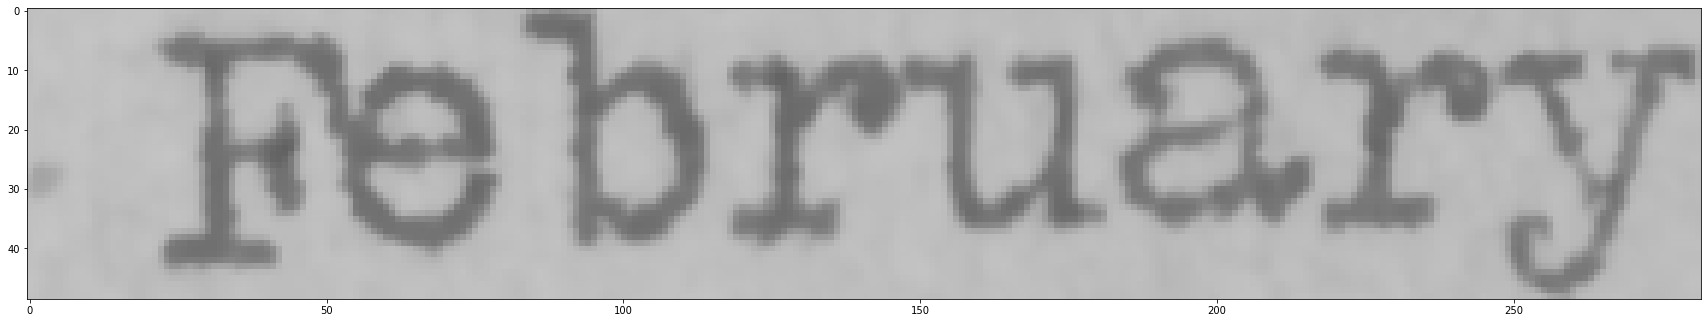

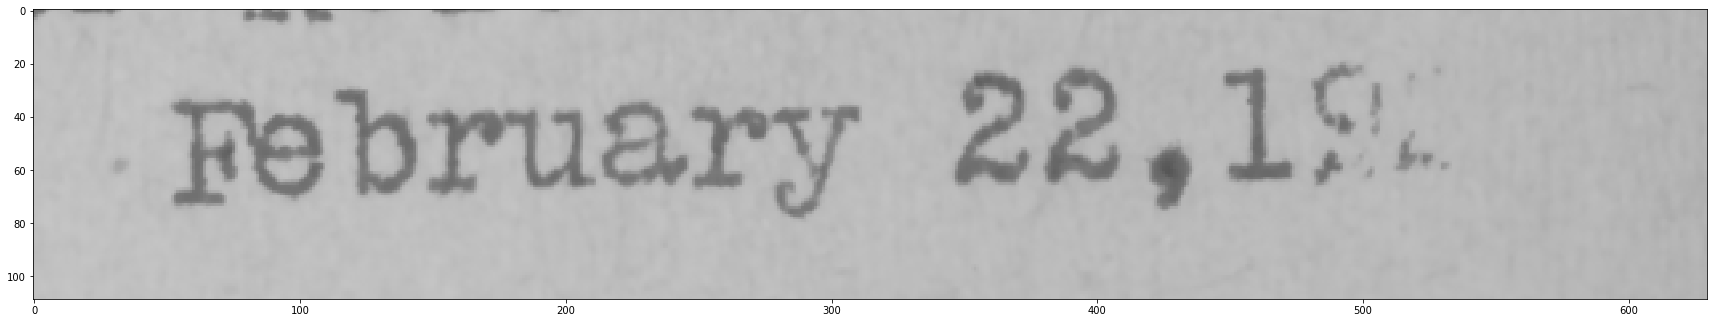

Processing 0012_004266_000254_0001.tif
0 nan
1 nan
2 nan
3 nan
4 ,
5 7
6 nan
7 ,
8 SPECIAL
9 NEWS
10 SERVICE
11 a
12 nan
13 DIVISION
14 OF
15 EXT
16 nN
17 Sion
18 axe
19 OTHER
20 AGENCIES
21 nan
22 KNOXVILLE
23 TENNessce
24 ,
25 nan
26 Prepared
27 by
28 the
29 Division
30 of
31 Extension,
32 nan
33 co
34 ,
35 University
36 of
37 Tennessee
38 For
39 Release
40 nan
41 oo
42 7
43 May
[]
May
['May']
2120
['May', 2120]
815
['May', 2120, 815]
103
['May', 2120, 815, 103]
53
44 17,
45 1926
46 nan
47 CHAMPION
48 COTTON
49 PRODUCER
50 iitCt
51 nan
52 TELLS
53 HOW
54 HE
55 GREW
56 To
57 a
58 nan
59 ,
60 BALES
61 PER
62 ACRE
63 pe
64 ,
65 a
66 ,
67 nan
68 Prent
69 Hudson,
70 a
71 club
72 boy
73 of
74 Haywood
75 county
76 who
77 grew
78 one
79 and
80 a
81 half
82 bales
83 of
84 ,
85 nan
86 cotton
87 on
88 an
89 acre
90 of
91 land
92 in
93 1924
94 and
95 bales
96 in
97 1925
98 has
99 given
100 out
101 some
102 of
103 his
104 ,
105 nan
106 methods
107 used
108 last
109 year
110 that
111 will
112 be
1

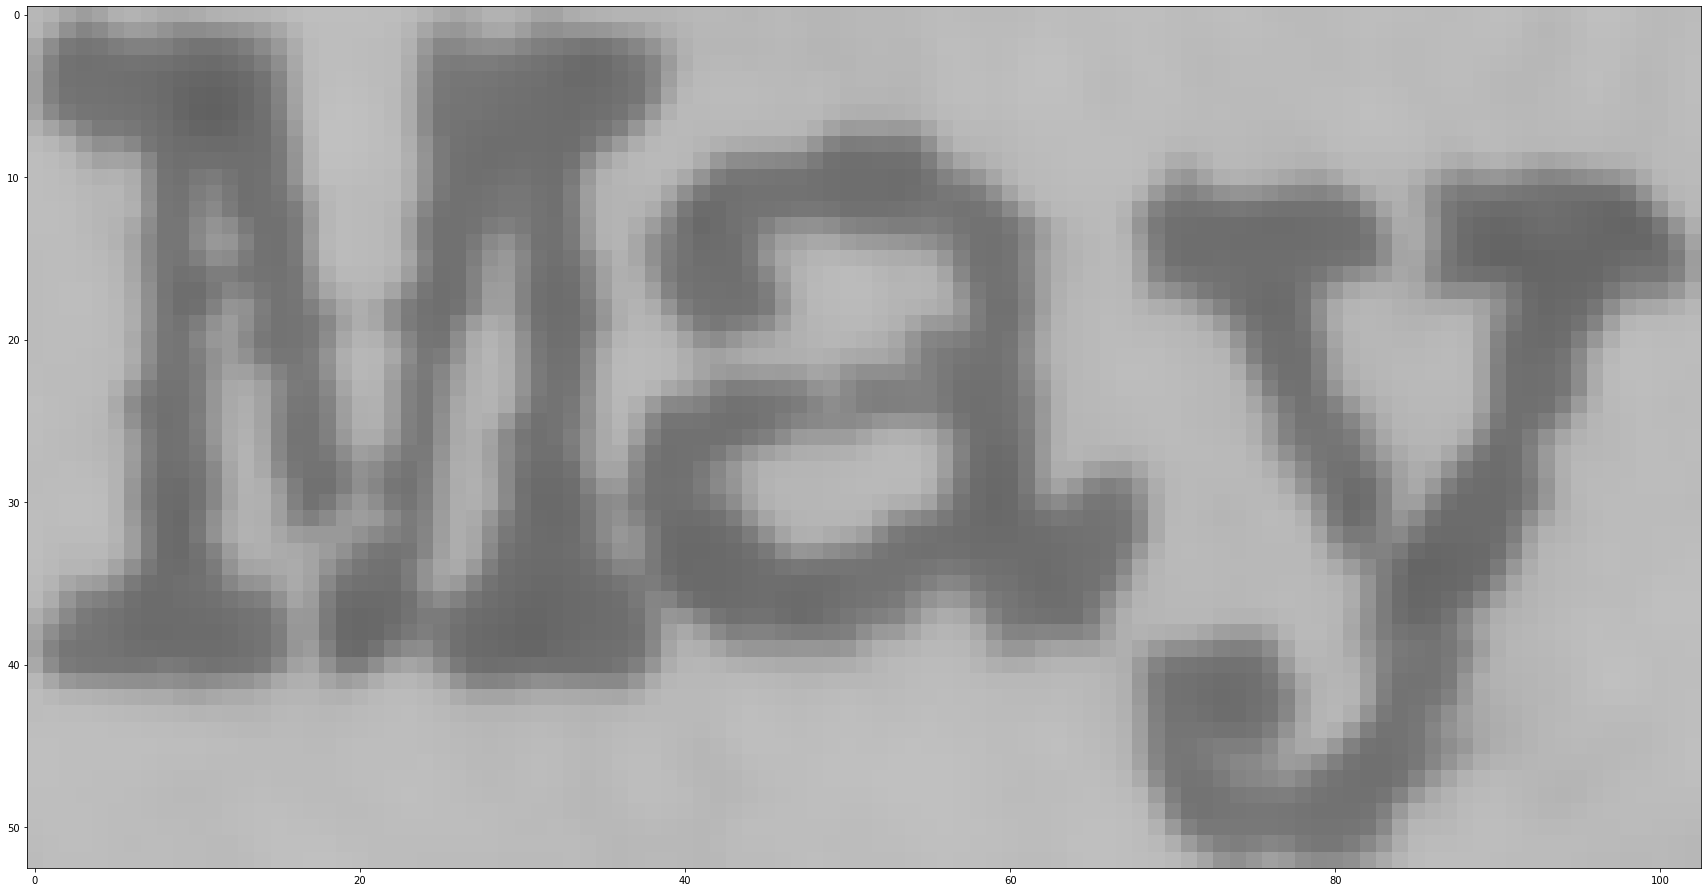

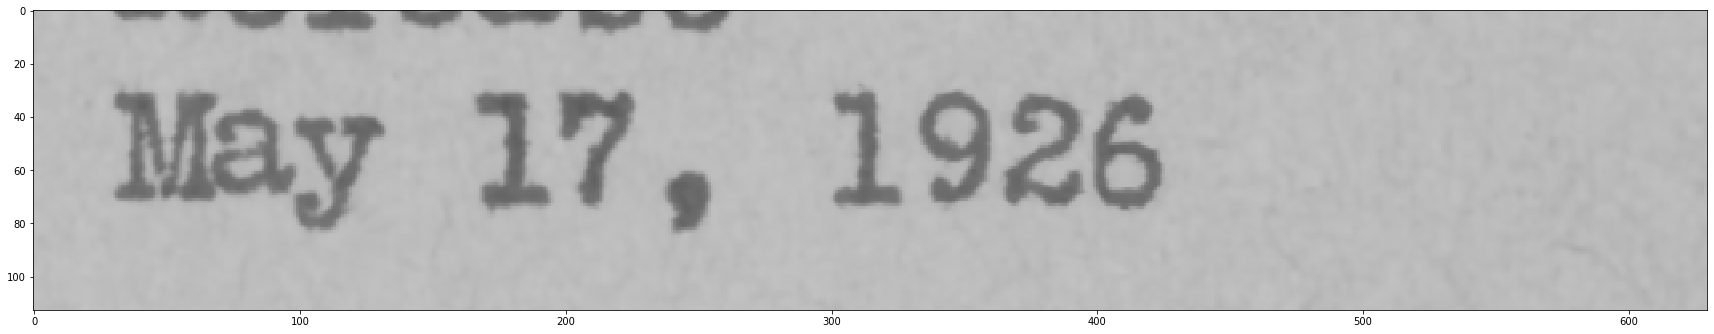

Processing 0012_004266_000260_0001.tif
0 nan
1 nan
2 nan
3 nan
4 a
5 ,
6 oe
7 e
8 ,
9 tinal
10 eum
11 nan
12 sree
13 vews
14 sevice
15  MNMUMINIMII
16 nan
17 Reece
18 wl
19 ggag
20 oaa7suNo
21 7h
22 nan
23 BIVISION
24 OF
25 EXTENSION
26 Seger
27 ,
28 oe
29 nan
30 onan
31 TENNESSEE
32 ,
33 nan
34 TENNESSEE
35 FARM
36 NEWS
37 nan
38 a
39 Prepared
40 byt
41 in
42 eee
43 of
44 Extension,
45 For
46 Release
47 nan
48 en
49 ,
50 University
51 Tennessee
52 June
[]
June
['June']
2522
['June', 2522]
757
['June', 2522, 757]
127
['June', 2522, 757, 127]
71
53 28,1975
54 nan
55 CO
56 FARM
57 THOUGHTS
58 ss
59 ,
60 nan
61 re
62 FOR
63 JULY
64 ,
65 nan
66 Specialists
67 of
68 the
69 Agricultural
70 Extension
71 Service
72 of
73 the
74 State
75 College
76 of
77 nan
78 Agriculture,
79 University
80 of
81 Tennessee
82 ,
83 offer
84 the
85 following
86 timely
87 thoughts
88 for
89 the
90 nan
91 consideration
92 of
93 busy
94 farmers
95 for
96 the
97 month
98 of
99 July,
100 nan
101 oo
102 Crop
103 Yields

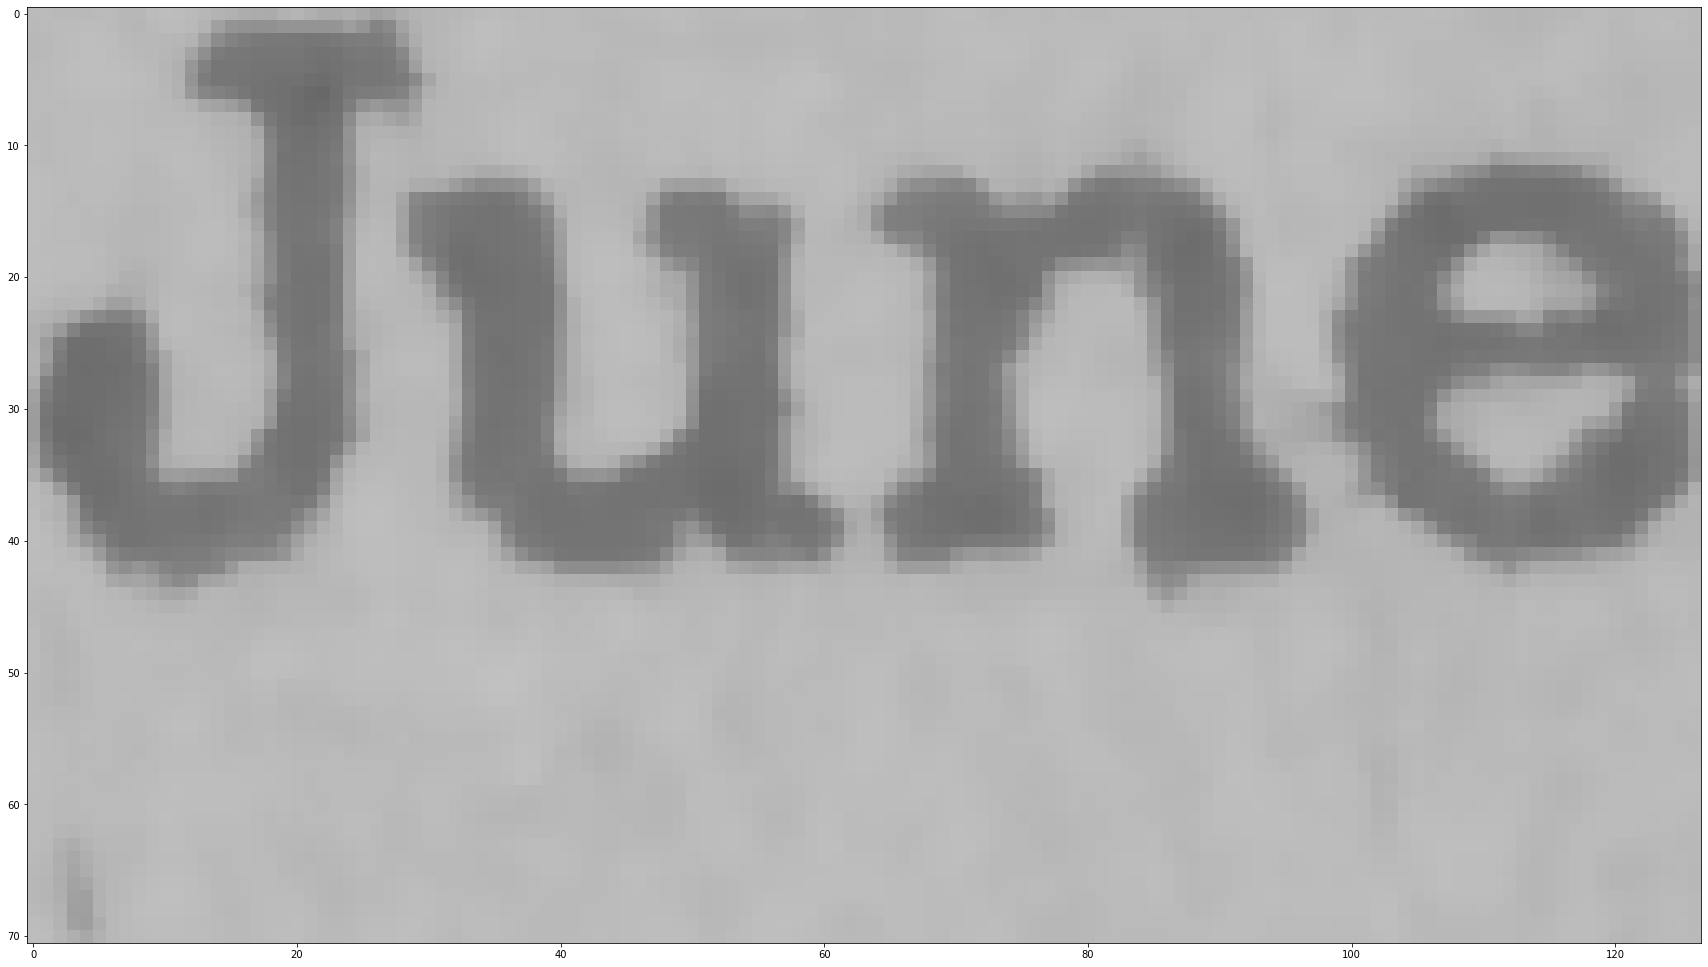

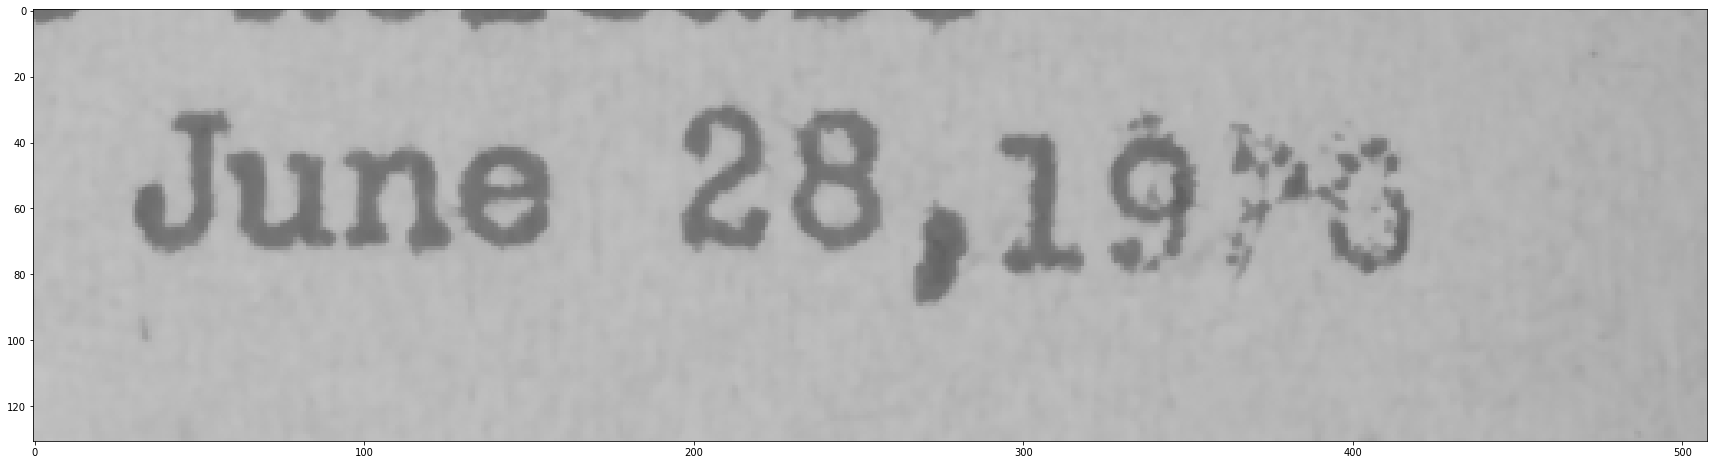

Processing 0012_004266_000280_0001.tif
0 nan
1 nan
2 nan
3 nan
4 nt
5 Boe
6 ee
7 ea
8 ee
9 nan
10 ,
11 Te
12 eae
13 eneeennnnanannicnnccnaacnc
14 ence
15 erence
16 anna
17 TT
18 NT
19 I
20 ST
21 HT
22 nan
23 f
24 SPECIAL
25 NEWS
26 SERVICE
27 ee
28 nan
29 pO
30 UNITED
31 STATES
32 OEPARTMENT
33 OF
34 AGRICULTURE
35 Cotta
36 foe,
37 ,
38 mE,
39 a
40 o
41 Br
42 Tee
43 Po
44 eet
45 s
46 nan
47 5
48 i
49 COLLEGE
50 OF
51 AGRICULTURE,
52 UNIVERSITY
53 OF
54 TENNESSEE
55 OO
56 ye
57 ed
58 ,
59 re
60 LO
61 nan
62 r
63 t
64 TENNESSEE
65 DEPARTMENT
66 OF
67 AGRICULTURE
68 A
69 rr
70 Lo
71 wet
72 hae
73 gh
74 eg
75 co
76 eye
77 roe,
78 soe
79 nan
80 po
81 TENNESSEE
82 BORO
83 OF
84 EDUCATION,
85 AND
86 OTHER
87 AGENCIES
88 a
89 py
90 4
91 ae
92 oe
93 oe
94 cet
95 tes
96 a
97 a
98 Ca
99 ag
100 o
101 oe
102 a
103 nan
104 Bp
105 DIVISION
106 OF
107 EXTENSION
108 fy
109 ee
110 Z
111 nan
112 Bt
113 Ch
114 bez
115 cmacvon
116 ee
117 ee
118 ee
119 eg
120 a
121 SOUS
122 me
123 ea
124 Ms
125 Pee
126 se
1

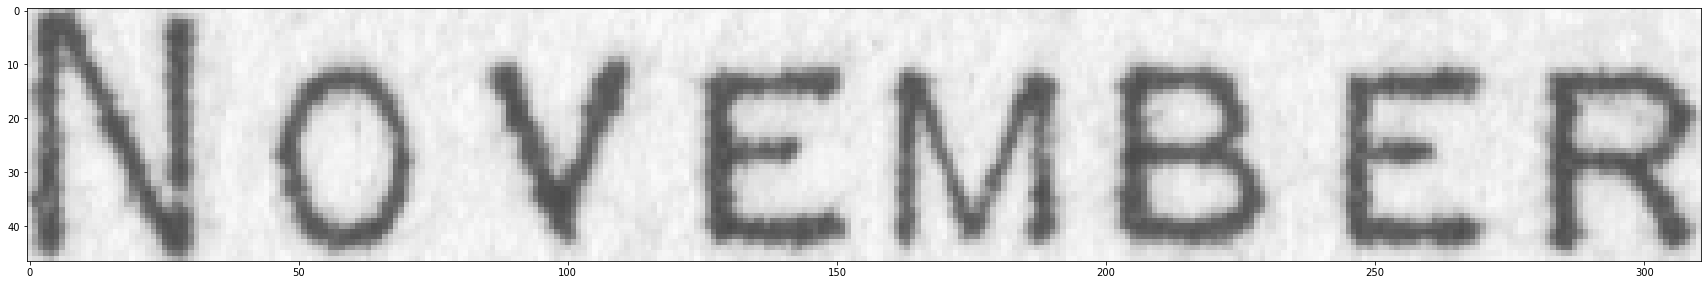

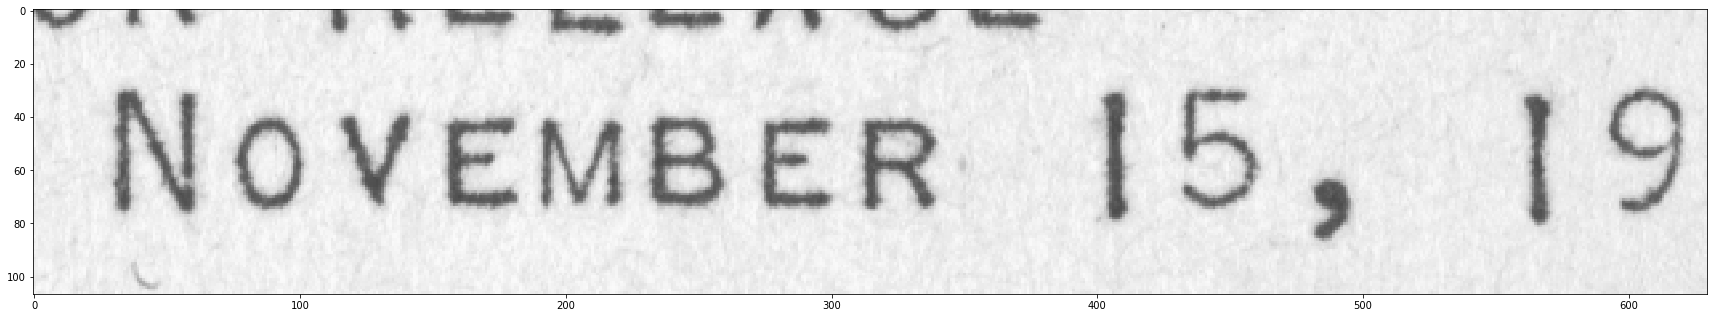

Processing 0012_004266_000289_0001.tif
0 nan
1 nan
2 nan
3 nan
4 See
5 namin
6 viene
7 ae
8 a
9 aa
10 a
11 ASR
12 eas
13 maa
14 aaa
15 a
16 raceme
17 nan
18 4
19 ,
20 fo,
21 e
22 s
23 i,
24 e
25 Not
26 rr
27 a
28 a
29 hs
30 vat
31 ae
32 pee
33 wee
34 Doe
35 an
36 To
37 a
38 foot
39 nan
40 nan
41 Be
42 rs
43 oO,
44 7
45 we
46 os
47 oo
48 oe
49 1
50 ,
51 Wee
52 vad
53 ode
54 me
55 e
56 eo
57 5
58 a
59 Y
60 on
61 a
62 a
63 oh
64 i
65 nan
66 i
67 a
68 ye
69 ww
70 a
71 ae
72 a
73 ce
74 x
75 Meee
76 a
77 De
78 woe
79 2
80 ao
81 ut
82 s
83 oes
84 oo
85 Ace
86 Q
87 ,
88 nan
89 no
90 a
91 oe
92 Le
93 pone
94 te
95 ,
96 a
97 oo,
98 an
99 ee
100 cp
101 ae
102 ,
103 a
104 nan
105 if
106 SPECIAL
107 NEWS
108 SERVICE,
109 4000
110 84
111 nan
112 be
113 GOOPERATIVE
114 AGRICULTURAL
115 EXTENSION
116 WORK
117 ee
118 a
119 nan
120 S
121 ,
122 UNITED
123 STATES
124 OEPARTMENT
125 OF
126 AGRICULTURE
127 pe
128 ST
129 Me
130 Pgopke
131 ee
132 se
133 Cr
134 s
135 eo
136 Ny
137 BO
138 nan
139 Be
140 ,
141 C

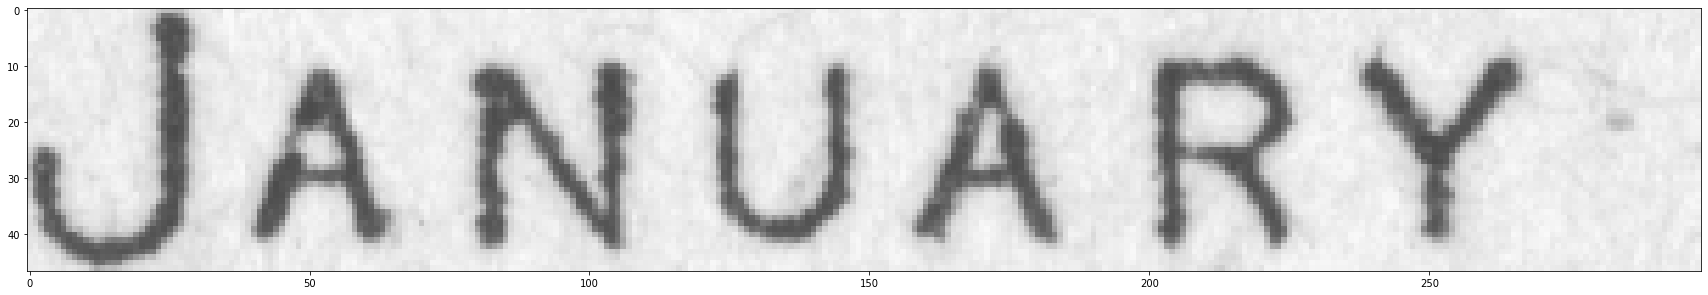

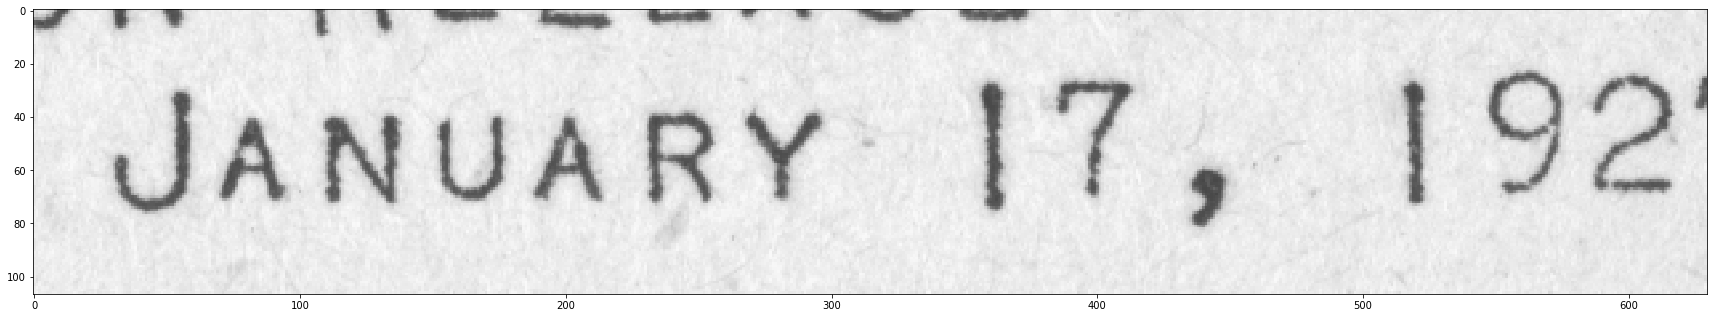

Processing 0012_004266_000309_0001.tif
0 nan
1 nan
2 nan
3 nan
4 i
5 ee
6 Ee
7 Te
8 a
9 nan
10 Boxy
11 SPECIAL
12 NEWS
13 SERVICE
14 9
15 ot
16 ge,
17 Bt
18 a
19 es
20 Pm
21 nan
22 Pc,
23 COOPERATIVE
24 AGRICULTURAL
25 EXTENSION
26 WORK
27 04
28 ete
29 ne
30 Be
31 ee
32 nan
33 i
34 7
35 UNITED
36 STATES
37 DEPARTMENT
38 OF
39 AGRICULTURE
40 ee
41 os
42 Oo
43 SE
44 a
45 a
46 nan
47 DF
48 COLLEGE
49 OF
50 AGRICULTURE,
51 UNIVERSITY
52 OF
53 TENNESSEE
54 27
55 0
56 fe
57 ES
58 ne
59 ae
60 Se
61 AO
62 nan
63 BS
64 ,
65 FENNESSEE
66 DEPARTMENT
67 OF
68 AGRICULTURE
69 ees
70 a
71 re
72 ct
73 aor
74 ee
75 be
76 igo
77 3
78 nan
79 u
80 No,
81 FENNESSEE
82 BOARD
83 OF
84 EDUCATION,
85 AND
86 OTHER
87 AGENCIES
88 oe
89 oe
90 a
91 We
92 SSS
93 y
94 Sy
95 Hehe
96 a
97 a
98 oe
99 ee
100 i
101 fe
102 ek
103 nan
104 DIVISION
105 OF
106 EXTENSION
107 0
108 gags
109 Mo
110 oe
111 To
112 BE
113 es
114 a
115 nan
116 ES
117 oy
118 KNOXVILLE,
119 TENNESSEE
120 od
121 ae
122 nd
123 WEE
124 EE
125 a
126 vite

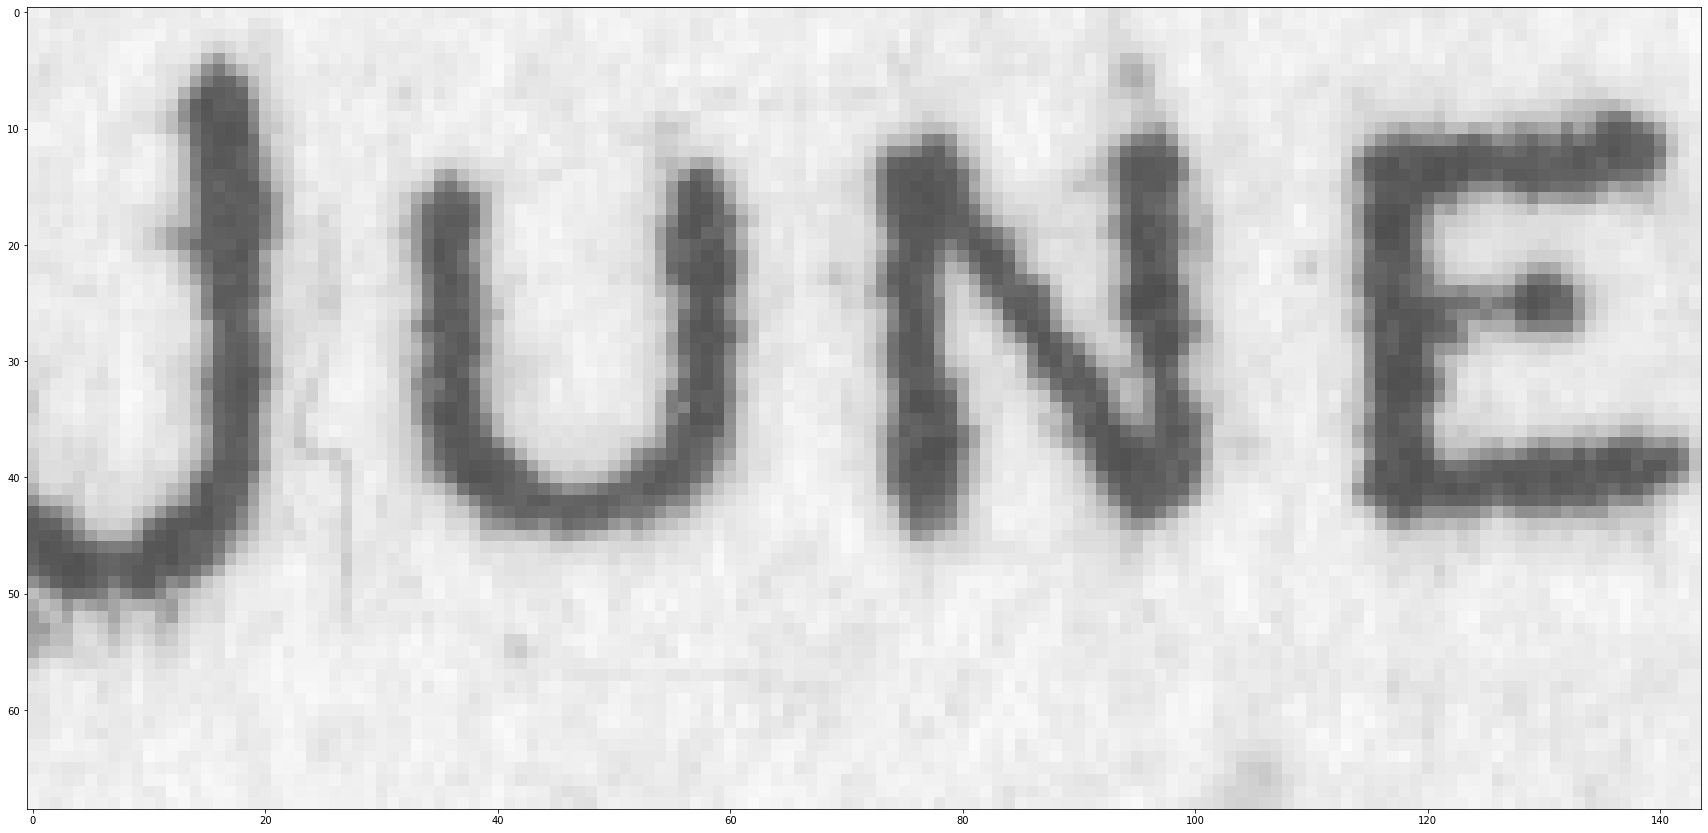

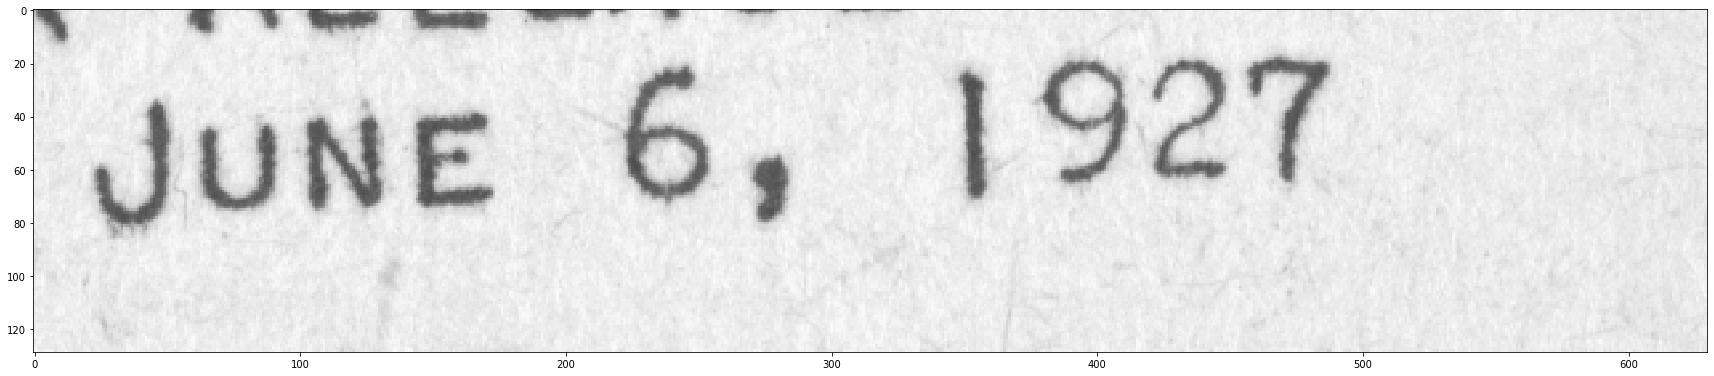

Processing 0012_004266_000325_0001.tif
0 nan
1 nan
2 nan
3 nan
4 Mi
5 Bo
6 ee
7 eEeEEEEEeE
8 ea
9 a
10 eee
11 ee
12 eee
13 nan
14 So
15 siege
16 capers
17 ieee
18 A
19 a
20 Re
21 RR
22 TEST
23 IE
24 oT
25 ee
26 ee
27 Ee
28 HE
29 I
30 Te
31 Se
32 TN
33 RI
34 RTI
35 A
36 AA
37 Raleieeie
38 nan
39 Po
40 SPECIAL
41 NEWS
42 SERVICE
43 De
44 oe
45 oat
46 yoo
47 Sg
48 rN
49 ng
50 nan
51 ee
52 sCOOPERATIVE
53 AGRICULTURAL
54 EXTENSION
55 WORK
56 es
57 we,
58 Se
59 Jao
60 ey
61 a
62 weg
63 nan
64 ee
65 UNITED
66 STATES
67 DEPARTMENT
68 OF
69 AGRICULTURE
70 we
71 os
72 a
73 77
74 oO
75 y
76 fet
77 a
78 nan
79 aa
80 COLLEGE
81 OF
82 AGRICULTURE,
83 UNIVERSITY
84 OF
85 TENNESSEE
86 Oe
87 ch
88 pe
89 a,
90 Ce
91 et
92 nan
93 1
94 7s,
95 TENNESSEE
96 DEPARTMENT
97 OF
98 AGRICULTURE
99 4A
100 2
101 poe
102 res
103 SF
104 Ls
105 Soy
106 ora
107 co
108 we
109 nan
110 Bp
111 os,
112 TENNESSEE
113 BOARD
114 OF
115 EDUCATION,
116 AND
117 OTHER
118 AGENCIES
119 Cy
120 Sak
121 Lo
122 woh
123 te
124 ag
125 t

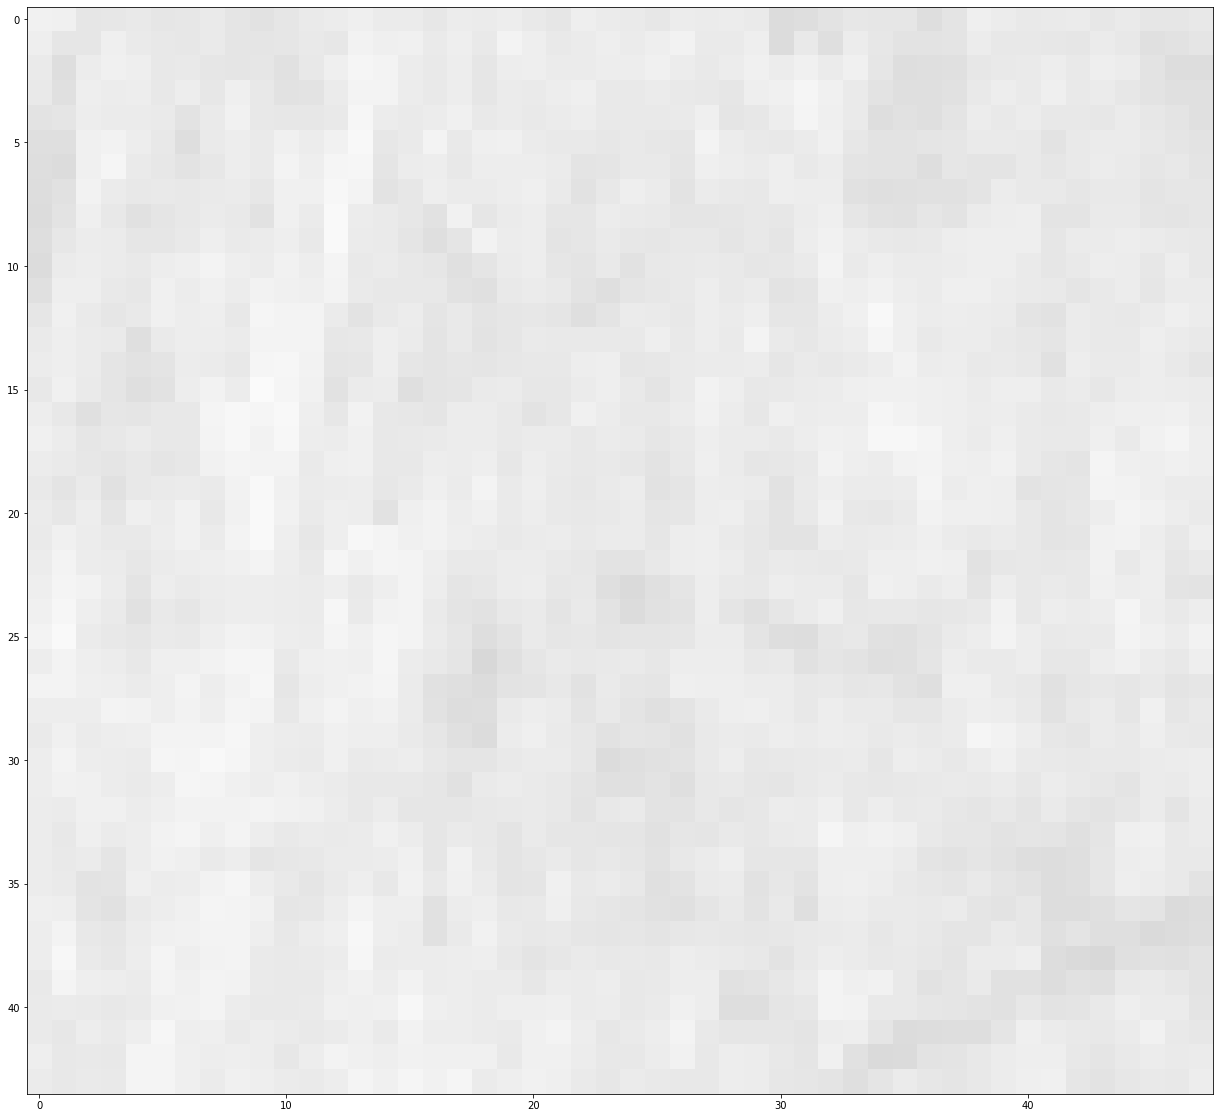

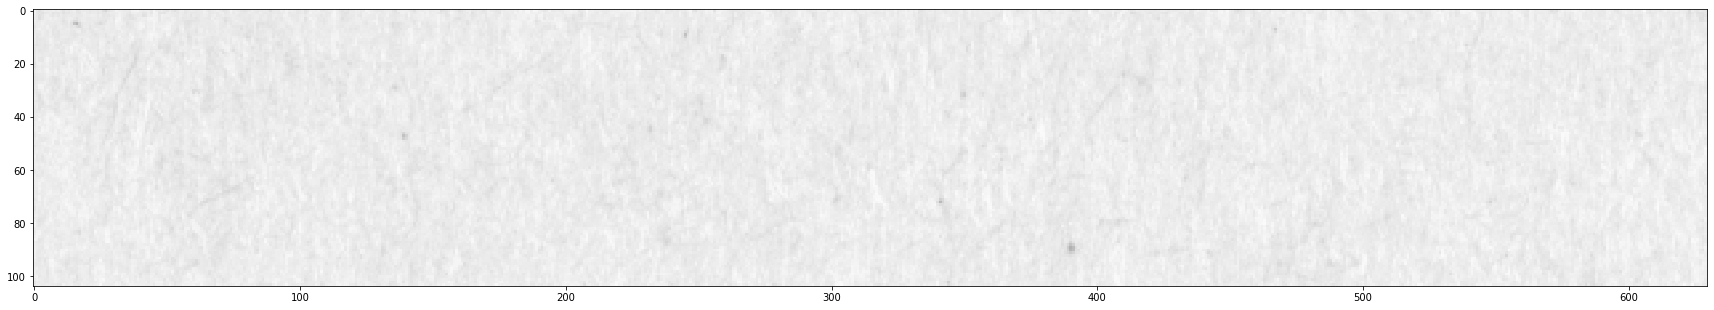

Processing 0012_004266_000346_0001.tif
0 nan
1 nan
2 nan
3 nan
4 beet
5 ae
6 Boe
7 UN
8 Pow
9 t
10 ,
11 nan
12 ott
13 Be
14 ea
15 BT
16 A
17 EP
18 gt
19 Oe
20 nan
21 a
22 S
23 ,
24 oo
25 a
26 ,
27 tf
28 a
29 t
30 a
31 ,
32 vs
33 poe
34 oo,
35 2
36 ,
37 no
38 vn
39 a
40 ae
41 oF,
42 aa
43 7
44 nan
45 a
46 L
47 2
48 ek
49 oo,
50 ,
51 ovat
52 my
53 ote
54 CoE
55 Cobol
56 me
57 oT
58 oe
59 7
60 gt
61 nan
62 ssi
63 SPECIAL
64 NEWS
65 SERVICE
66 0
67 Oe
68 et
69 ee
70 nan
71 4
72 COOPERATIVE
73 AGRICU
74 Be
75 ee
76 TR,
77 SO
78 or
79 ne
80 arn
81 we
82 Be
83 of
84 nan
85 r
86 my
87 UNITED
88 STATES
89 SRICULTURAL,
90 EXTENSION
91 WORK
92 a
93 ee
94 ee
95 ot
96 oe
97 eg
98 oe
99 nan
100 va
101 oH,
102 COLLEGE
103 OF
104 AGRICULTURE,
105 UNIVERSITY
106 OF
107 TENNESSE
108 ee
109 a
110 te
111 Res
112 ltr
113 te
114 nan
115 TENNESSEE
116 DEPARTMENT
117 OF
118 AGRICULTURE
119 By
120 te
121 ,
122 oe
123 sr
124 os
125 nan
126 Qf
127 4
128 TENNESSEE
129 BOARO
130 OF
131 EDUCATION,
132 AND
133 OTHER

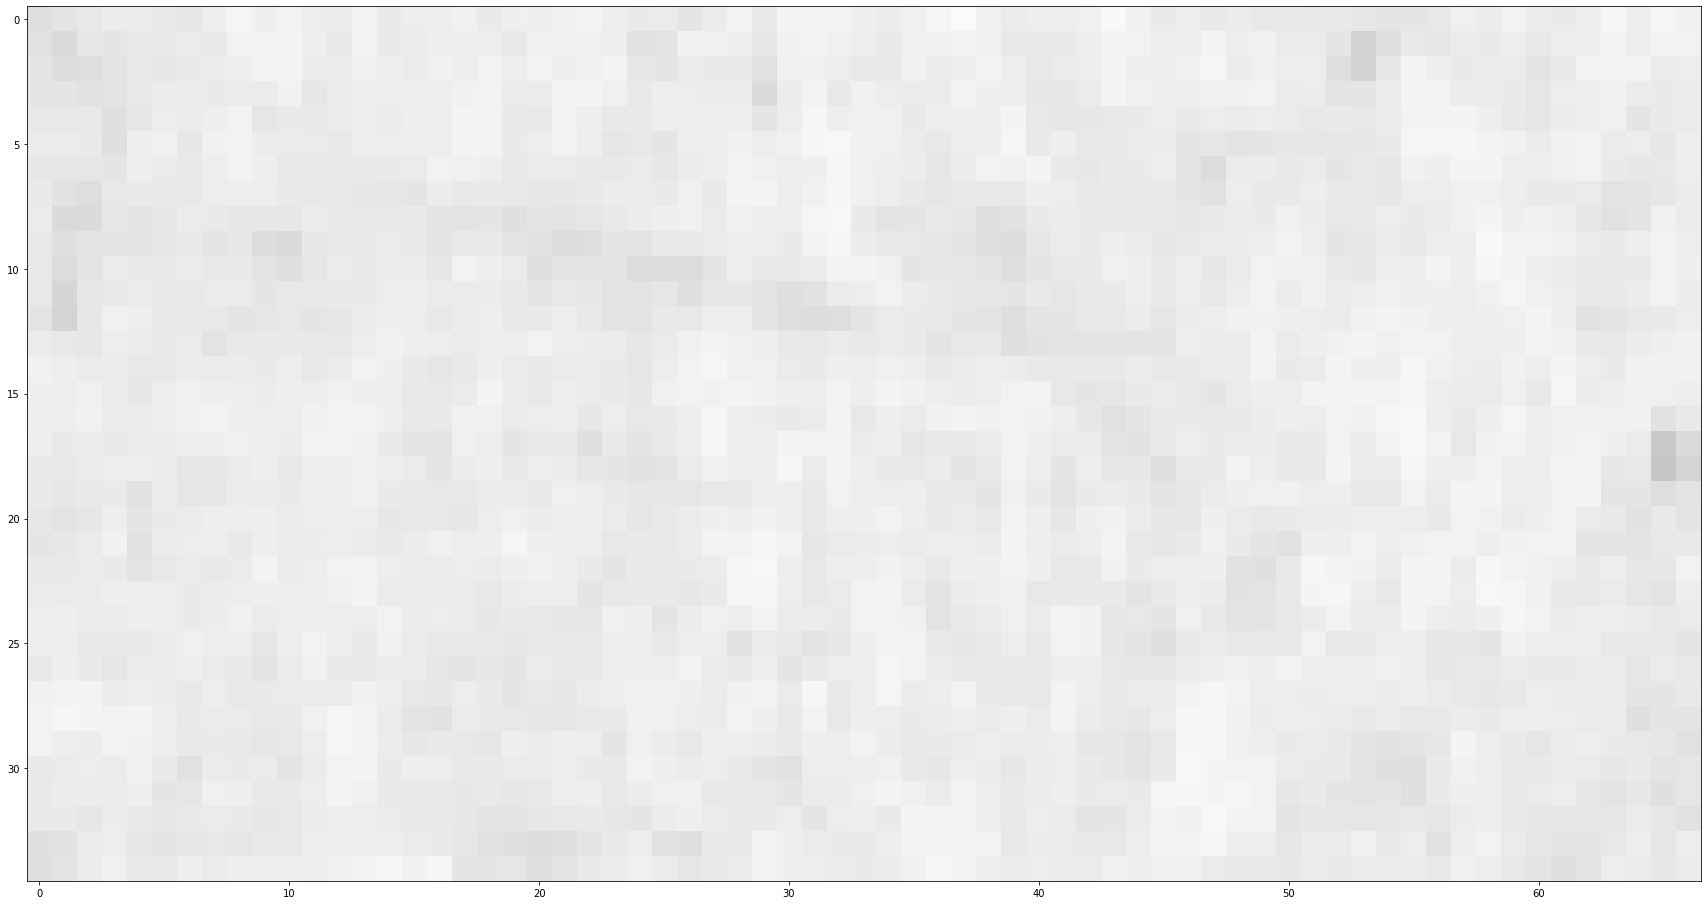

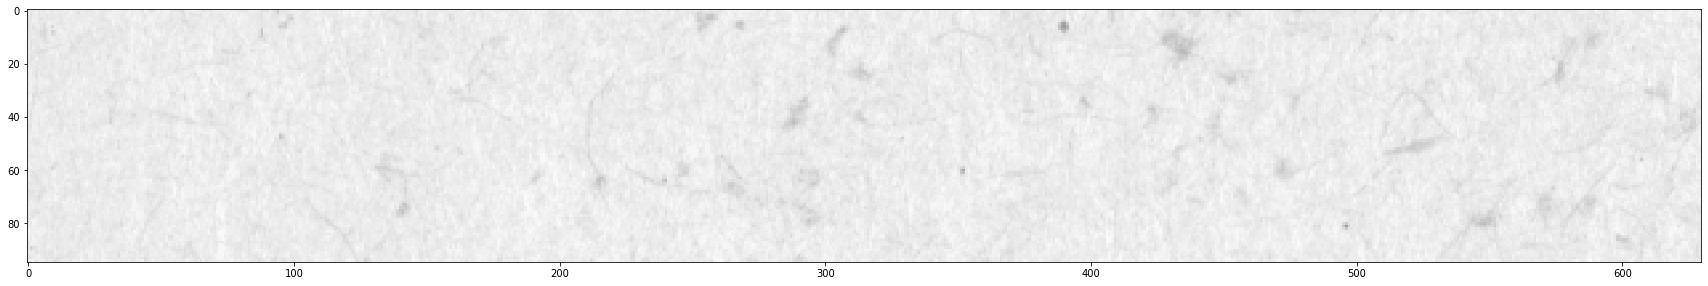

Processing 0012_004266_000369_0001.tif
0 nan
1 nan
2 nan
3 nan
4 pe
5 Te
6 De
7 ee
8 re
9 Cy
10 rome
11 ne
12 A
13 ot
14 co
15 ys
16 ve
17 nan
18 ce
19 2
20 4
21 os
22 wm
23 Coe
24 s
25 ws
26 ot
27 St
28 oO
29 po
30 2
31 S
32 i
33 er
34 aa
35 a
36 te
37 2
38 ao,
39 2D
40 ,
41 nan
42 ti
43 SPECIAL
44 NEWS
45 SERVICE,
46 2
47 7
48 ue
49 dee
50 ey
51 tn
52 Fa
53 ee
54 oe
55 nan
56 oA
57 ,
58 COOPERATIVE
59 AGRICULTURAL
60 EXTENSION
61 WORK
62 ey
63 te,
64 Sa
65 nan
66 oo
67 ss
68 UNRITEO
69 STATES
70 OEPARTMENT
71 Of
72 AGRICULTURE
73 Load
74 pom
75 FR
76 Tak
77 a
78 ne
79 Meg,
80 oe
81 nan
82 ns
83 CORLEGE
84 OF
85 AGRICULTURE,
86 UNIVERSITY
87 OF
88 TENNESSEE
89 Cope
90 es
91 oe
92 OE
93 ge,
94 Be
95 ype
96 By
97 4
98 nan
99 me
100 FENNESSEE
101 OEPARTMENT
102 OF
103 AGRICULTURE
104 oa
105 a
106 Be
107 bone
108 cet,
109 ve
110 aE
111 in
112 Tom
113 nan
114 1,
115 TENNESSEE
116 BOARD
117 OF
118 EDUCATION,
119 AND
120 OTHER
121 AGENCIQ
122 Pe
123 BR
124 a
125 es
126 ,
127 re
128 re
129 we

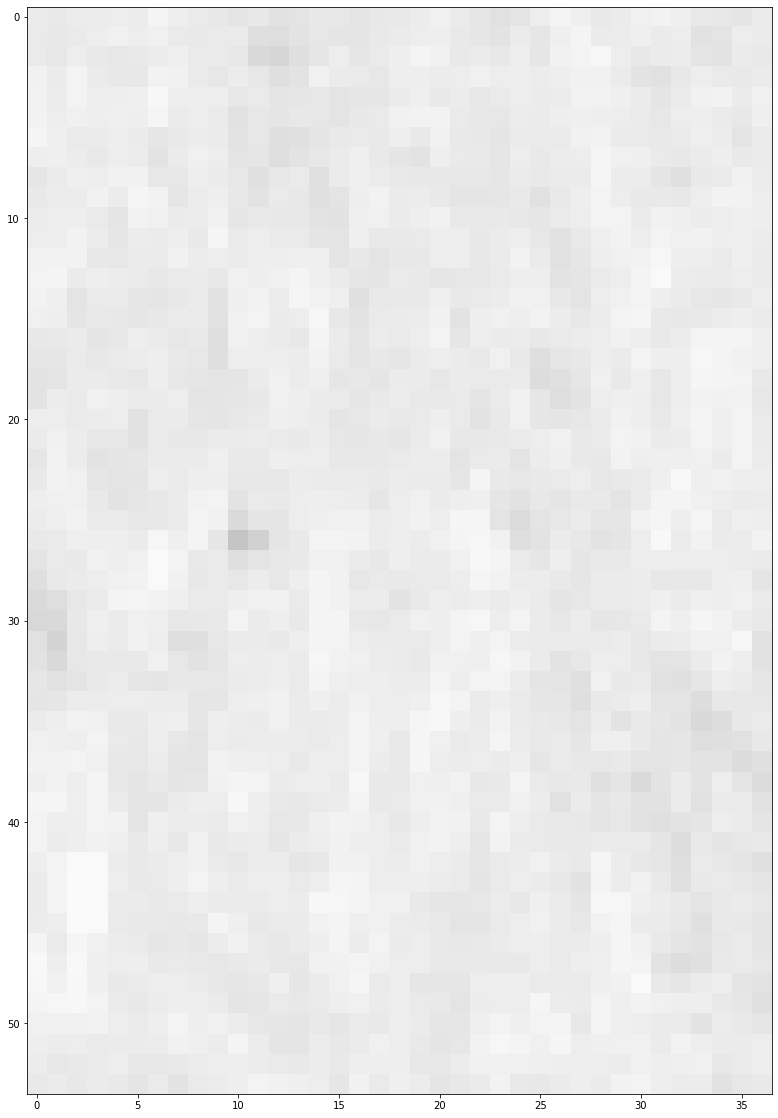

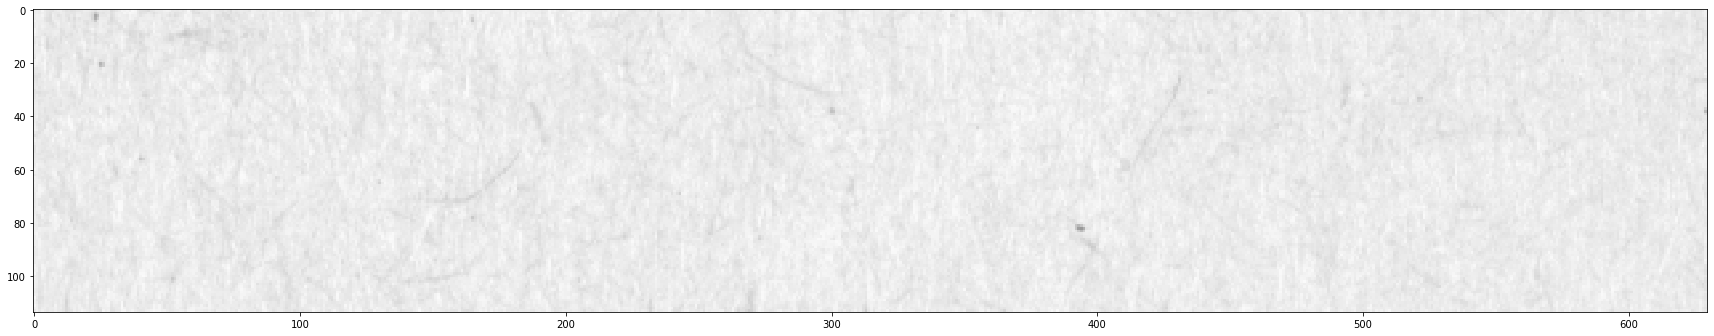

Processing 0012_004266_000414_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 oo,
8 ,
9 ,
10 a
11 a
12 nan
13 COOPERATIVE
14 AGRICULTURAL
15 EXTENSION
16 WORK
17 t
18 oy
19 so
20 nan
21 WMATED
22 STATES
23 OEPARTMENT
24 OF
25 AGRICULTURE
26 ,
27 a
28 o7
29 nan
30 COLLEGE
31 OF
32 AGMCULTURE,
33 UNIVERSITY
34 OF
35 TENNESSEE
36 s
37 ,
38 nan
39 TENNERSEE
40 DEPARTMENT
41 OF
42 AGRICULTURE
43 m
44 ,
45 nan
46 TENNESSEE
47 BOARD
48 OF
49 EOUCATION,
50 ANO
51 OTHER
52 AGENCIER
53 ,
54 1
55 ,
56 nan
57 DMISION
58 OF
59 EXTENSION
60 oNy
61 a
62 nan
63 Ch
64 LA
65 yg
66 manacven
67 ,
68 a
69 i
70 ,
71 mo
72 nan
73 NORVILLE,
74 TENNESORE
75 Lo
76 ,
77 nan
78 ,
79 TENNESSEE
80 FARM
81 NEWS
82 nan
83 Do
84 so
85 Prepared
86 by
87 the
88 Division
89 of
90 Extension,
91 7
92 ct
93 nan
94 So
95 me
96 ,
97 ,
98 University
99 of
100 Tennessee
101 ae
102 SO
103 nan
104 ,
105 Doe
106 ,
107 JUNE
[]
JUNE
['JUNE']
2301
['JUNE', 2301]
820
['JUNE', 2301, 820]
147
['JUNE', 2301, 820, 147]
47
10

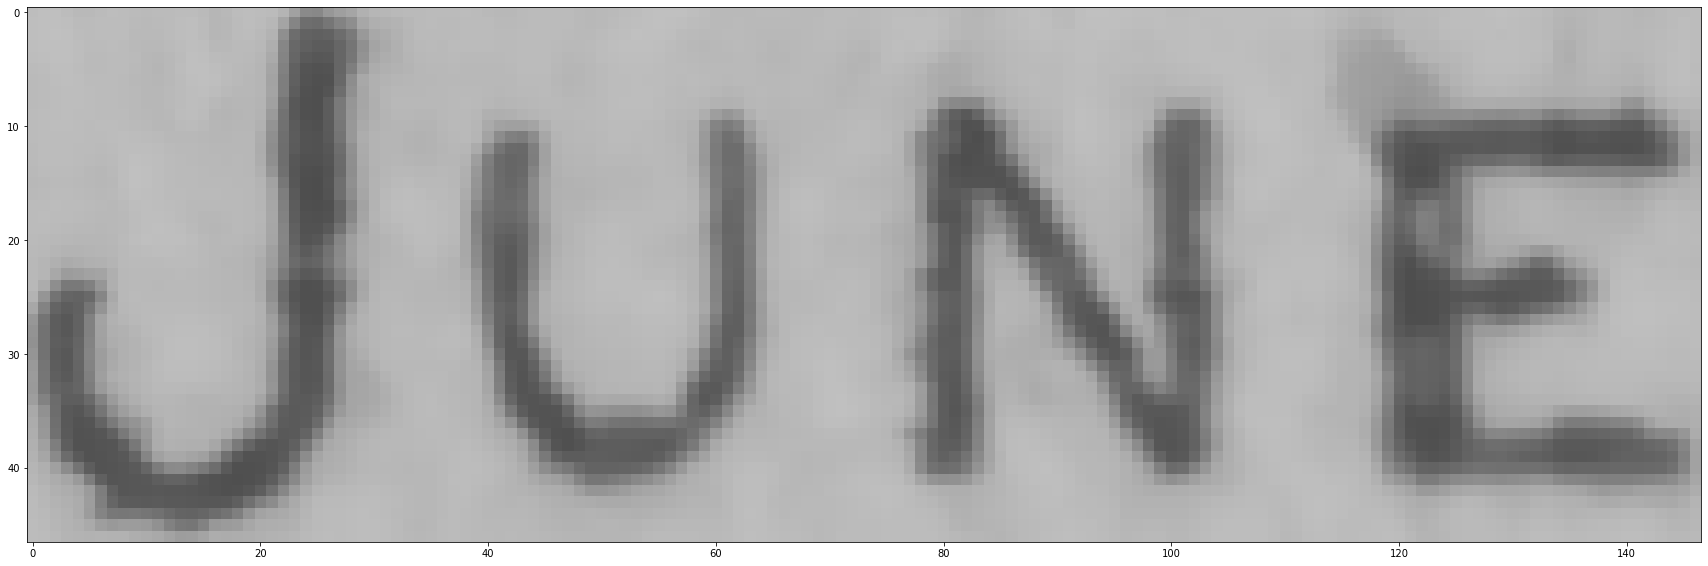

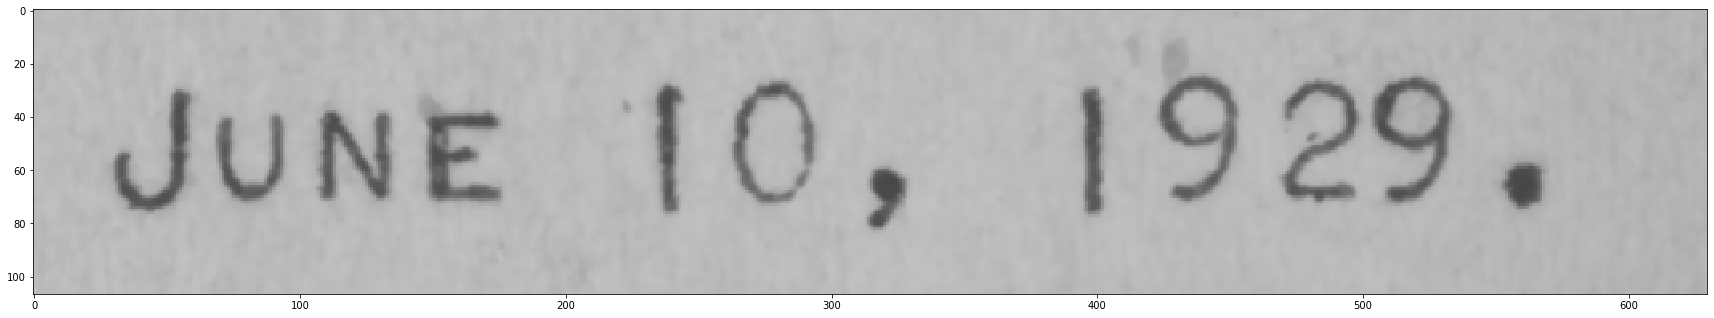

Processing 0012_004266_000433_0001.tif
0 nan
1 nan
2 nan
3 nan
4 t
5 i
6 SPECIAL
7 NEWS
8 SERVICE
9 6
10 00
11 nan
12 we
13 o7,
14 8
15 GOOPERATIVE
16 AGRICULTURAL
17 EXTENSION
18 WORK
19 77
20 ag
21 te
22 Py
23 nan
24 Bev
25 fl
26 2
27 UNITED
28 STATES
29 DEPARTMENT
30 OF
31 AGRICULTURE
32 TE
33 ae
34 Ci
35 es
36 wt
37 nan
38 ON
39 st
40 os
41 COLLEGE
42 OF
43 AGRICULTURE,
44 UNIVERSITY
45 OF
46 TENNESSEE
47 ete
48 ae
49 a
50 AOS
51 yp
52 ee
53 Fe
54 ee
55 a
56 EE
57 nan
58 pe
59 TE
60 ON
61 TENNESSEE
62 DEPARTMENT
63 OF
64 AGRICULTURE
65 a
66 ee
67 EN
68 ge
69 ga
70 ee
71 nan
72 po
73 sgt
74 iL
75 TENNESSEE
76 BOARD
77 OF
78 EDUCATION,
79 AND
80 OTHER
81 AGENCIES
82 8,
83 oO
84 ae
85 ar
86 ee
87 a3
88 ae
89 thee,
90 ra
91 a
92 Tae
93 we
94 nan
95 fe
96 1,
97 AGRICULTURAL
98 EXTENSION
99 SERVICE
100 2120
101 fo
102 8
103 ee
104 a
105 Be
106 nan
107 oe
108 es
109 wo
110 ey
111 KNOXVILLE,
112 TENNESSEE
113 y
114 a
115 ooo
116 MP
117 A
118 bs
119 oa
120 me
121 o
122 ae
123 eh
124 wa
125 

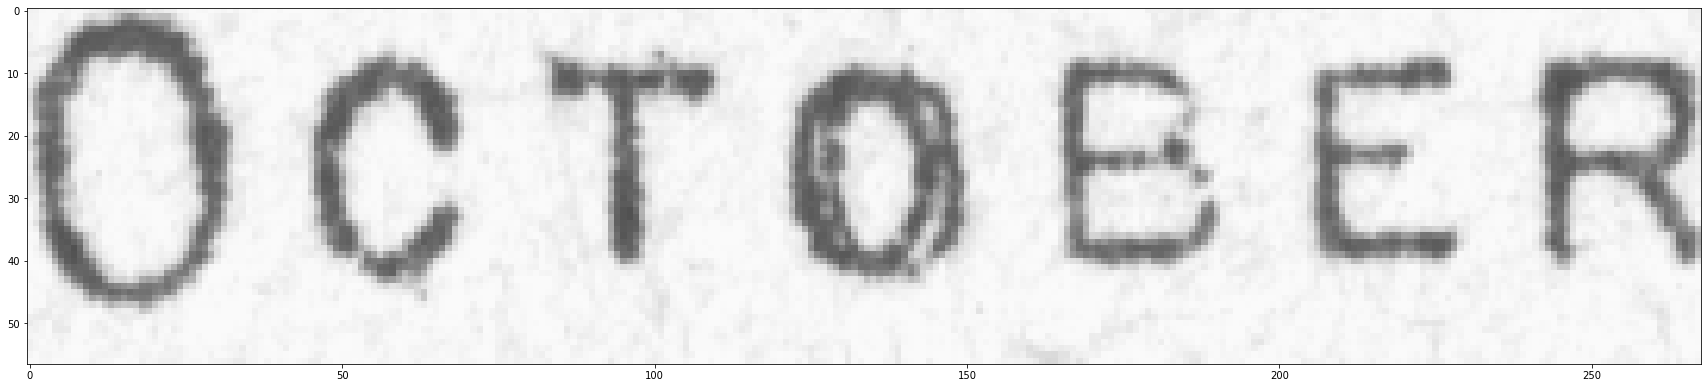

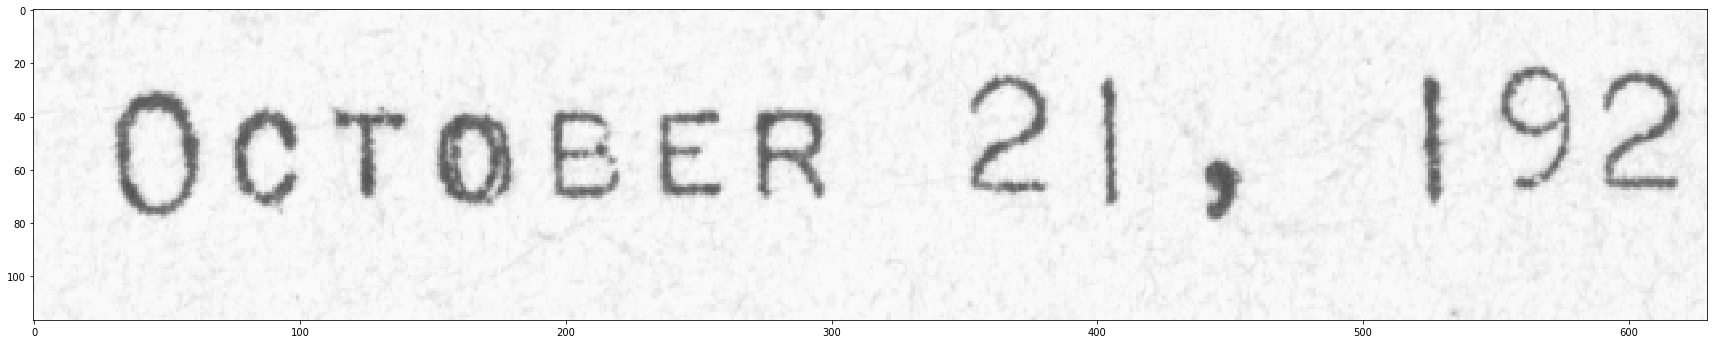

Processing 0012_004266_000456_0001.tif
0 nan
1 nan
2 nan
3 nan
4 Mo
5 SPECIAL
6 NEWS
7 SERVICE
8 so
9 Coe
10 oy
11 me
12 a
13 oe
14 2
15 fo
16 a
17 7,
18 nan
19 Bo
20 Ss
21 a
22 GOOPERATIVE
23 AGRICULTURAL
24 EXTENSION
25 WORK
26 Be
27 BE
28 Pt
29 Co
30 nan
31 yt
32 UNITED
33 STATES
34 DEPARTMENT
35 OF
36 AGRICULTURE
37 re
38 ee
39 ree
40 oh
41 nan
42 ae
43 GOLLEGE
44 OF
45 AGRICULTURE,
46 UNIVERSITY
47 OF
48 TENNESSEE
49 me
50 Cs
51 Ba
52 Ces
53 Do
54 nan
55 ae
56 TENNESSEE
57 DEPARTMENT
58 OF
59 AGRICULTURE
60 oo
61 I
62 ee
63 So
64 a
65 a
66 nan
67 o
68 a
69 ue
70 ,
71 TENNESSEE
72 BOARD
73 OF
74 EDUCATION,
75 AND
76 OTHER
77 AGENCIES
78 so
79 te
80 a
81 ,
82 on
83 7
84 oe
85 oe
86 Oe
87 ps
88 ne
89 ,
90 nan
91 a
92 oe
93 AGRICULTURAL
94 EXTENSION
95 SERVICE
96 oo
97 ,
98 oo
99 Te
100 a
101 wo
102 eee
103 re
104 eed
105 nan
106 ao
107 a
108 Ch
109 LAG
110 fr
111 DIRECTOR
112 eA
113 oe
114 Co,
115 o
116 Oe
117 AS
118 ,
119 oe
120 ,
121 os
122 a
123 nan
124 es
125 oe
126 Ley
127 KNOXV

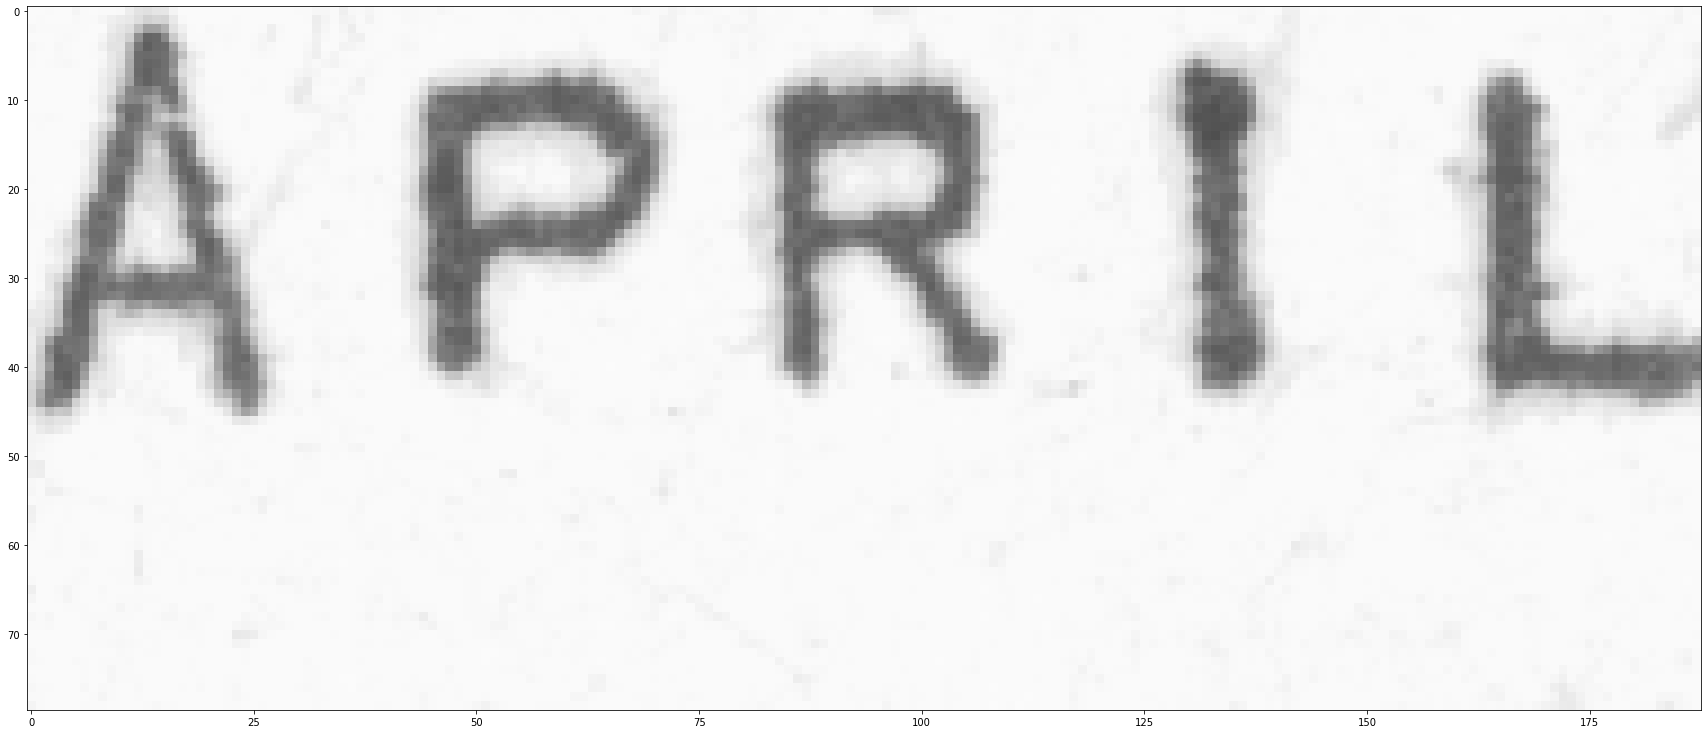

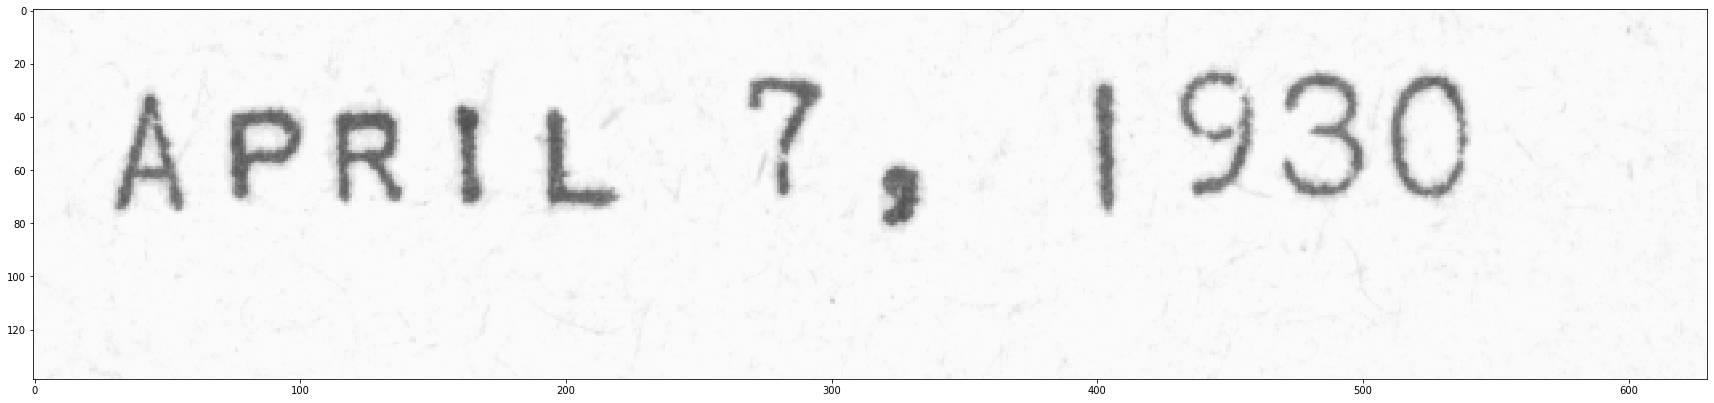

Processing 0012_004266_000474_0001.tif
0 nan
1 nan
2 nan
3 nan
4 SPECIAL
5 NEWS
6 SERVICE
7 07
8 po
9 nan
10 Lo
11  SQOPERATIVE
12 AGRICULTURAL
13 EXTENSION
14 WORK
15 oe
16 oo
17 CO
18 co
19 2
20 own
21 re
22 nan
23 2
24 SIMTare
25 earns
26 cocaine
27 oe
28 a
29 ae
30 a
31 nan
32 foo
33 TENNESSEE
34 DEPARTMENT
35 OF
36 AGRICULTURE
37 eo
38 oar
39 ,
40 De
41 a
42 nan
43 nan
44 Po
45 Ye,
46 TENNESSEE
47 BOARD
48 OF
49 EDUCATION,
50 AND
51 OTHER
52 AGENCIES
53 7
54 oo
55 i
56 Lot
57 es
58 To
59 no
60 Ss
61 nan
62 po
63 AGRICULTURAL
64 EXTENSION
65 SERVICE
66 nan
67 ee
68 a
69 a
70 Ch
71 AK
72 fpr
73 viREcTOR
74 a
75 m
76 Of
77 re
78 oS
79 a
80 oy
81 a
82 eo,
83 wee
84 mS
85 Be
86 a
87 wo
88 nan
89 poo
90 4
91 me
92 KNOXVILLE,
93 TENNESSEE
94 ce
95 Po
96 aan
97 an
98 cla
99 oS
100 nan
101 b
102 oe
103 ae
104 s
105 ,
106 x
107 Z
108 tod
109 tf
110 A
111 2
112 nan
113 nan
114 po
115 a
116 ae
117 Agricultural
118 Extension
119 Service
120 a
121 op
122 ores
123 nan
124 poo
125 a
126 Og
127 Oo

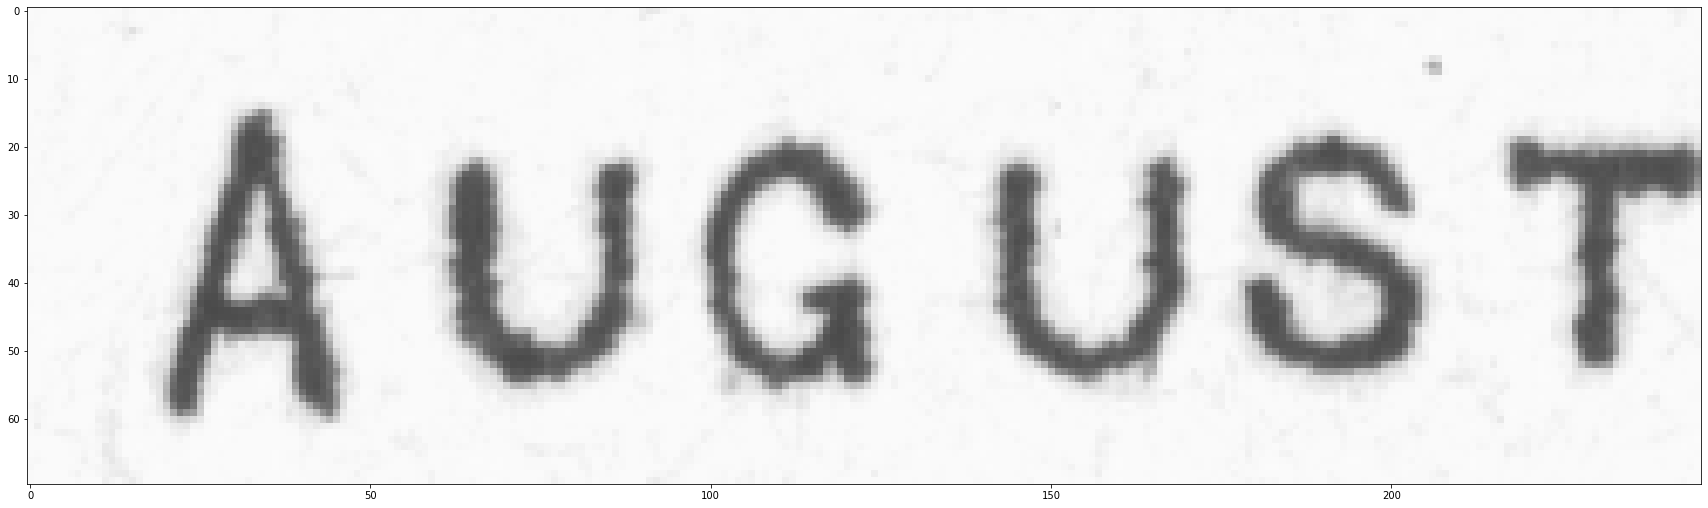

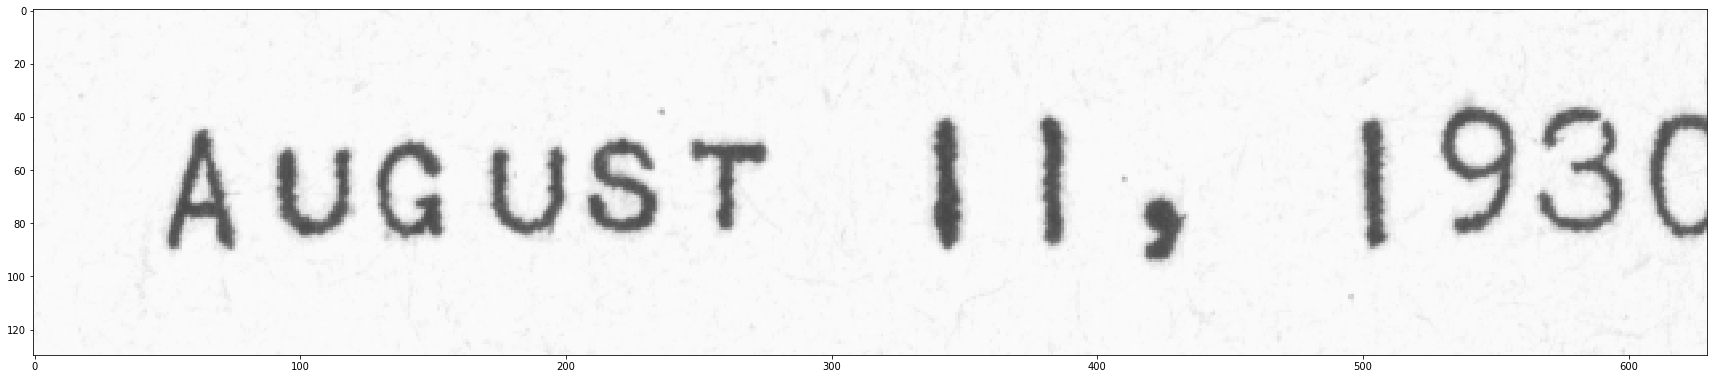

Processing 0012_004266_000493_0001.tif
0 nan
1 nan
2 nan
3 nan
4 700
5 SPECIAL
6 NEWS
7 SERVICE
8 nan
9 moO
10  ,
11 QMOPRRATIVE
12 AGRICULTURAL
13 EXTENBION
14 WORK
15 a
16 ee
17 BE
18 nan
19 Do
20 be
21 UNITED
22 STATES
23 DEPARTMENT
24 OF
25 AGRICULTURE
26 oe
27 acs
28 a
29 Ch
30 DO
31 ar
32 i
33 nan
34 os
35 SOLLEGE
36 OF
37 AGRICULTURE,
38 UNIVERSITY
39 OF
40 TENNESSEE
41 Doe
42 oe
43 ior
44 wm
45 SEE
46 Se
47 Ee
48 cet
49 y
50 nan
51 eh
52 S
53 TRNNESSEE
54 DEPARTMENT
55 OF
56 AGRICULTURE
57 a
58 Ce
59 ty
60 eb
61 De,
62 Be
63 nan
64 qo
65 WENNESSER
66 BOARD
67 OF
68 EDUCATION,
69 ANDOTHER
70 AGENCIES
71 Eg
72 ee
73 a
74 nan
75 o
76 ,
77 AGRICULTURAL
78 EXTENSION
79 SERVICE
80 RE
81 nan
82 2
83 Ce
84 mt
85 LS
86 Chal
87 MtGfpae
88 dinectoR
89 ge
90 oe
91 ws
92 ede
93 4
94 oe
95 oe
96 ae
97 Pe
98 ae
99 Hes
100 oe
101 De
102 a
103 nan
104 vi
105 ,
106 he
107 a
108 a
109 KNOXVILLE,
110 TENNESSEE
111 an
112 re
113 o
114 an
115 Be
116 7
117 3
118 oN
119 a
120 oe
121 oo
122 nan
123 pee

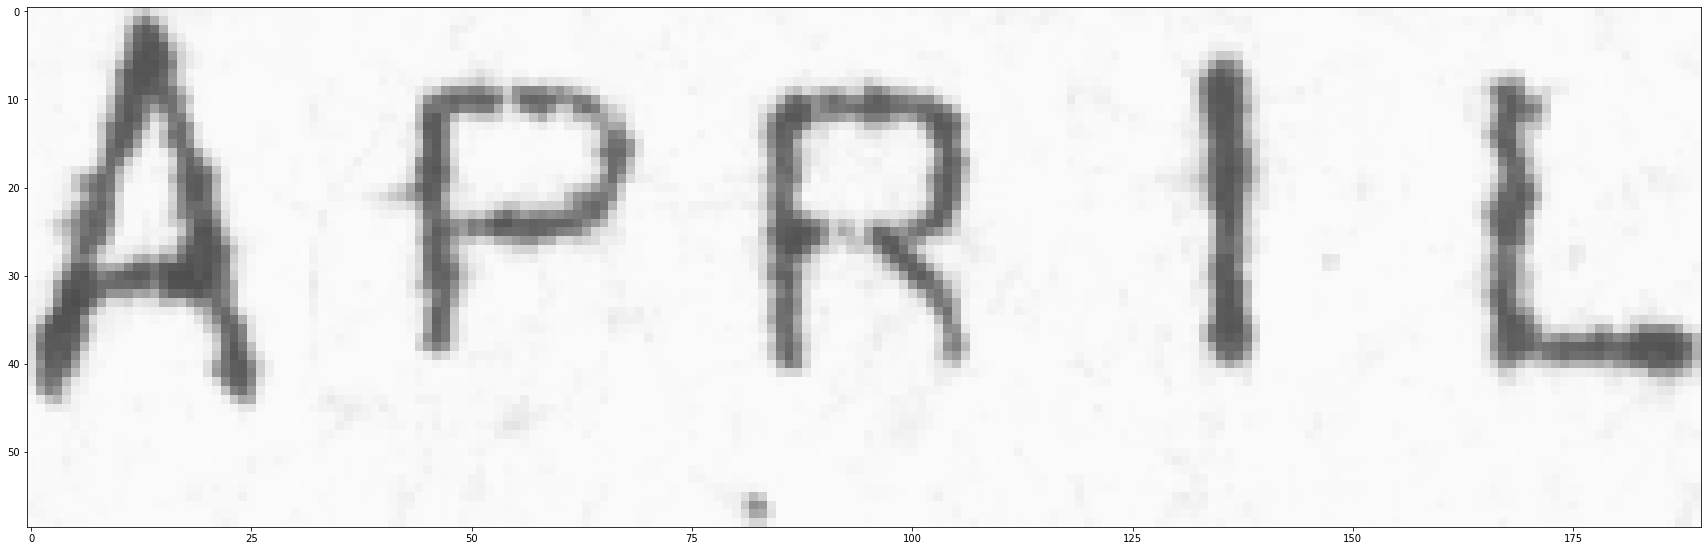

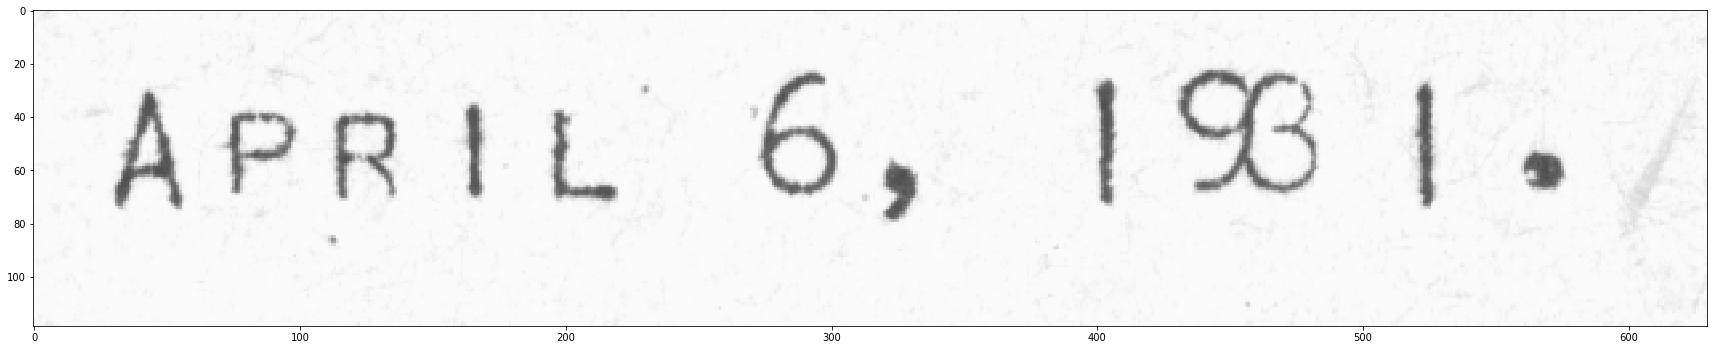

Processing 0012_004266_000520_0001.tif


KeyboardInterrupt: 

In [143]:
for image_path in tqdm(page_1_paths_list):
    print(f'Processing {image_path.name}')
    month_crop, date_crop = get_date_crop(image_path)
    if len(month_crop) > 0:
        bgr_imshow(month_crop)
        bgr_imshow(date_crop)

In [ ]:
def deskew(image):

    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    gray = cv2.medianBlur(gray, 5)
    gray = cv2.bitwise_not(gray)
    binarized = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # binarized = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 55, 11)
    # plt.imshow(binarized, cmap='gray'), plt.show()
    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(binarized > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    
    # print(angle)
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # bgr_imshow(image)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # bgr_imshow(rotated)
    
    return rotated

In [ ]:
percentage = 0.4

for image_path in page_1_paths_list[5:10:25]:
    print(image_path.stem)
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)
    top_and_sides_padding = 100
    x1 += top_and_sides_padding
    y1 += top_and_sides_padding
    x2 -= top_and_sides_padding
    y2 += top_and_sides_padding
    image = image[y1:y2, x1:x2]
    
    rotated = deskew(image)
    
    variables = [ocr_dataframe, box, text, x1, y1, box_width, box_height, x2, y2]
    for variable in variables:
        variable = ''
    
    # OCR and load results as Pandas dataframe
    ocr_dataframe, ocr_text, binarized, test_boxes = return_date(rotated)
    
    words = ocr_text.lower().split()
    best_word = {}
    best_ratio = 90
    for month in months:
        # print(month)
        result = process.extractOne(month, words)
        word, ratio = result[:2]
        if ratio > best_ratio:
            best_word.update({month: word})
    print(best_word)
    print(100 * '*')
    print(test_boxes)

In [ ]:
percentage = 0.4
top_and_sides_padding = 100
roi_box_list = ['text', 'left', 'top', 'width', 'height']

for image_path in page_1_paths_list[::100]:
    print(image_path.stem)
    
    variables = [ocr_dataframe, ocr_text, binarized, box, text, x1, y1, box_width, box_height, x2, y2]
    for variable in variables:
        variable = ''
    
    image = crop_image_for_ocr(image_path, percentage=percentage, top_and_sides_padding=top_and_sides_padding)
    
    original = image.copy()
    
    # OCR and load results as Pandas dataframe
    ocr_dataframe, ocr_text, binarized = return_date(image)
    
    find_date = True
    for index, ocr_result in enumerate(ocr_dataframe['text']):
        if find_date:
            # print(find_date)
            if isinstance(ocr_result, float):  # skip NaN values
                pass
            else:
                if ocr_result.lower() in months:
                    box_month, box_day, box_year = [], [], []
                    boxes = [box_month, box_day, box_year]
                    for box in boxes:
                        if isinstance(ocr_dataframe.iloc[index]['text'], str):  # skip NaN values
                            for data in roi_box_list:
                                box.append(ocr_dataframe.iloc[index][data])
                            index += 1
                    find_date = False
                    # print('NOW FALSE')
    if not find_date:
        if len(image.shape) < 3:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        bgr_imshow(image)
        plt.imshow(binarized, cmap='gray'), plt.show()
        
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))
        fig.suptitle(image_path.stem, fontsize=16)
        for index, box in enumerate(boxes):
            print(index, box)

            box = [int(x) if x != box[0] else x for x in box]
            try: 
                text, x1, y1, box_width, box_height = box
                x2 = x1 + box_width
                y2 = y1 + box_height

                # print(box)
                
                image_cropped = image[y1:y2, x1:x2]
                image_cropped_rgb = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
                axes[index].imshow(image_cropped_rgb)
                axes[index].set_title(text)
            except ValueError:
                pass
        plt.show()
    else:
        print('No date found')
        
        if len(original.shape) < 3:
            original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        bgr_imshow(original)
        plt.imshow(binarized, cmap='gray'), plt.show()
    print(ocr_text)
        

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for index, box in enumerate(boxes):
    print(box)
    box = [int(x) if x != box[0] else x for x in box]
    text, x1, y1, box_width, box_height = box
    x2 = x1 + box_width
    y2 = y1 + box_height

    # print(box)
    image_to_crop = cv2.imread(str(image_path))
    image_cropped = image_to_crop[y1:y2, x1:x2]
    image_cropped_rgb = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
    axes[index].imshow(image_cropped_rgb)
    axes[index].set_title(text)
plt.show()

In [ ]:
ocr_dataframe

In [ ]:
image = cv2.imread(str(image_path))

image = get_top_percent_of_image(image, 0.3)

bgr_imshow(image)

#image = cv2.resize(image,(0,0),fx=7,fy=7)

image = cv2.GaussianBlur(image,(9,9),0)

#image = cv2.medianBlur(image,9)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 55, 11) 

plt.imshow(image, cmap='gray')
plt.show()

#bgr_imshow(image)

In [ ]:
config='-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,\  --psm 6'
text = pytesseract.image_to_string(image,
                                   lang='eng',
                                   config=config)

In [ ]:
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

for line in text.split('\n'):
    words = line.split()
    for index, word in enumerate(words):
        if word.lower() in months:
            print(word)
            print(words[index:])

In [ ]:
image_path = page_1_paths_list[-100]
resize_width = 1600  # must be a multiple of 32
resize_height = 1600  # must be a multiple of 32
minimum_confidence = 0.5
padding = 25

In [ ]:
# load input image and get dimensions
image = cv2.imread(str(image_path))
original = image.copy()
(original_height, original_width) = image.shape[:2]

# set the new width and height then determine the ration in change
(new_width, new_height) = resize_width, resize_height
ratio_width = original_width / float(new_width)
ratio_height = original_height / float(new_height)

# resize the image and get the new dimensions
image = cv2.resize(image, (new_width, new_height))
(height, width) = image.shape[:2]

In [ ]:
# define the two output layer names for the EAST detector model
# 1st: output probabilities
# 2nd: used to derive the bounding box coordinates of text
layer_names = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

# load the pre-trained EAST detector
print("[INFO] loading EAST text detector . . . ")
net = cv2.dnn.readNet('data/frozen_east_text_detection.pb')

In [ ]:
# construct a blob from the image and perform a forward pass of the model
# to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (width, height), 
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layer_names)
end = time.time()

# show timing information on text predition
print(f'[INFO] text detection took {round((end - start), 6)} seconds')

In [ ]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(number_of_rows, number_of_columns) = scores.shape[2:4]
rectangles = []
confidences = []

# loop over the number of ys
for y in range(0, number_of_rows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that surround text
    scores_data = scores[0, 0, y]
    x_data_0 = geometry[0, 0, y]
    x_data_1 = geometry[0, 1, y]
    x_data_2 = geometry[0, 2, y]
    x_data_3 = geometry[0, 3, y]
    angles_data = geometry[0, 4, y]
    
    # loop over the number of columns
    for x in range(0, number_of_columns):
        # if our score does not have a sufficient probability, ignore it
        if scores_data[x] < minimum_confidence:
            continue
        
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offset_x, offset_y) = (x * 4.0, y * 4.0)
        
        # extract the rotation angle for the prediction and then
        # compute sin and cosine
        angle = angles_data[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        
        # use the geometry volume to derive the width and height of the bounding box
        bounding_box_height = x_data_0[x] + x_data_2[x]
        bounding_box_width = x_data_1[x] + x_data_3[x]
        
        # compute both the starting and ending (x, y)-coordinates for the
        # text prediction bounding box
        end_x = int(offset_x + (cos * x_data_1[x]) + (sin * x_data_2[x]))
        end_y = int(offset_y - (sin * x_data_1[x]) + (cos * x_data_2[x]))
        start_x = int(end_x - bounding_box_width)
        start_y = int(end_y - bounding_box_height)
        
        # add bounding box coordinates and probability score to respective lists
        rectangles.append((start_x, start_y, end_x, end_y))
        confidences.append(scores_data[x])

In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bouding boxes
boxes = non_max_suppression(np.array(rectangles), probs=confidences)

# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    start_x = int(start_x * ratio_width)
    start_y = int(start_y * ratio_height)
    end_x = int(end_x * ratio_width)
    end_y = int(end_y * ratio_height)
    
    # draw the bounding box on the image
    cv2.rectangle(original, (start_x, start_y), (end_x, end_y), (0, 255, 0), 8)

# show the output image
bgr_imshow(original)

In [ ]:
minimum_confidence = 0.9
padding = 5
(rectangles, confidences) = decode_predictions(scores, geometry)

# apply non-maxima suppression to suppress weak, overlapping bouding boxes
boxes = non_max_suppression(np.array(rectangles), probs=confidences)

# initialize the list of results
results = []

# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    start_x = int(start_x * ratio_width)
    start_y = int(start_y * ratio_height)
    end_x = int(end_x * ratio_width)
    end_y = int(end_y * ratio_height)
    
    # obtain a better OCR by adding padding
    delta_x = int((end_x - start_x) * padding)
    delta_y = int((end_y - start_y) * padding)
    
    # apply the padding to each side of the bounding box
    start_x = max(0, start_x - delta_x)
    start_y = max(0, start_y - delta_y)
    end_x = min(original_width, end_x + (delta_x * 2))
    end_y = min(original_height, end_y + (delta_y * 2))
    
    # extract the actual padded ROI
    roi = original[start_y:end_y, start_x:end_x]
    
    # set tesseract parameters
    # language: english, oem: 1, LSTM neural net model, psm: 7, single line of text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    
    # add the bounding box coordinates and OCR'd text to the list of results
    results.append(((start_x, start_y, end_x, end_y), text))
print(len(results))

In [ ]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])

# loop over the results
for ((start_x, start_y, end_x, end_y), text) in results[:10]:
    # display the text OCR'd by Tesseract
    print('OCR TEXT')
    print('========')
    print(f'{text}\n')
    
    # strip out the non-ASCII text and draw the texton the image using OpenCV
    # draw the text and a bounding box surrounding the text region of the input image
    text = ''.join([c if ord(c) < 128 else "" for c in text]).strip()
    output = original.copy()
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y),
                 (0, 0, 255), 6)
    cv2.putText(output, text, (start_x, start_y - 20),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 9)
    
    # show the output image
    bgr_imshow(output)